# MMP9 Inhibitor Classification

## Background

Machine learning is a powerful tool for the discovery of potential drug candidates. Traditional methods for screening small molecule libraries are expensive and time consuming. Additionally, only around 1-2% of the screened molecules turn out to be biologically active towards the protein of interest. Using a machine learning model to first predict which molecules are most likely to be active can significantly increase the percentage of useful molecules screened, thus decreasing the time and expense required to find potential drug candidates [Zorn et al, 2021](https://pubs.acs.org/doi/10.1021/acsinfecdis.0c00754). 

Matrix Metalloproteinases (MMPs) are a family of 24 proteins that regulate the extracellular matrix that holds cells together and keeps them in the proper place in your body. In many cancers, high levels of certain MMPs, especially MMP9, indicate that the tumor cells have been cleaved from their spot in body and are now circulating through the body, allowing the tumor to metastasize. This is correlated with a worse prognosis for the patient. Thus, medicines that inhibit the MMPs associated with metastic tumors offer a opportunity to improve the prognosis of cancer patients [Winer, et al. 2018](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5984693/)

## Business Understanding

Researchers working on matrix metalloproteinases are looking for new drugs that would inhibit cancer metastisis by inhibiting MMP9 activity. To increase the effectiveness of screening a small molecule library for potential candidates, they want to first use a machine learning model to identify the compounds most likely to have inhibitory activity against the MMP9 protein before doing the more expensive and time-intensive screening for activity in vitro. 

## Data Understanding

Data for this project was obtained from the [ChEMBL database](https://www.ebi.ac.uk/chembl/). The database contained 6418 bio-active molecules that had been tested for activity on MMP9. Of these molecules, 3592 had a reported IC50 (concentration of drug required to inhibit 50% of MMP9 activity) value and were used to create the model. The data from ChEMBL contains 45 features, but I only used 3- chembl_id, canonical SMILES (a representation of the molecule), and the IC50 value. The IC50 value was used to create a target category- 'inactive', 'active' or 'intermediate'. Finally, the canonical SMILES was used to create a database of chemical properities of the compounds using [PaDEL](http://www.yapcwsoft.com/dd/padeldescriptor/). The final dataset consisted of 2263 rows and 147 features representing various chemical properites of the compounds. 

## Data Preparation

For much of the data preparation and exploration, I followed tutorials from the Data Professor ([youtube](https://www.youtube.com/watch?v=plVLRashaA8), [github](https://github.com/dataprofessor/code/tree/master/python)). I added some exploration and rewrote code where I could make it more concise. 

In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import utils as ut

import matplotlib.pyplot as plt
import seaborn as sns


from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, AllChem, Draw

from numpy.random import seed
from numpy.random import randn
from scipy.stats import mannwhitneyu

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest, StackingClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance

from lazypredict.Supervised import LazyClassifier

import pickle

from chembl_webresource_client.new_client import new_client

/Users/cindyreiner/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


### Data gathering

The first step is to obtain a dataset from the ChEMBL library. The ChEMBL library has several different types of molecules in it's database. I will use the target database (contains proteins whose activity might be affected by the drug candidates) and the activity database (contains the activity data for drug candidates against specific targets). 

In [2]:
%%script echo skipping
# Use ChEMBL library to search for the drug target protein, MMP9, in the ChEMBL database

# Establish a query of the target database
target_mmp = new_client.target
# Search for MMP9
target_query = target_mmp.search('MMP9')
# Create & view a dataframe of results
targets_mmp = pd.DataFrame.from_dict(target_query)
targets_mmp

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'P50282', 'xref_name': None, 'xre...",Rattus norvegicus,Matrix metalloproteinase 9,14.00,False,CHEMBL3870,"[{'accession': 'P50282', 'component_descriptio...",SINGLE PROTEIN,10116
1,"[{'xref_id': 'NBK53808', 'xref_name': 'Gelatin...",Mus musculus,Matrix metalloproteinase 9,14.00,False,CHEMBL2214,"[{'accession': 'P41245', 'component_descriptio...",SINGLE PROTEIN,10090
2,"[{'xref_id': 'P52176', 'xref_name': None, 'xre...",Bos taurus,Matrix metalloproteinase-9,14.00,False,CHEMBL5846,"[{'accession': 'P52176', 'component_descriptio...",SINGLE PROTEIN,9913
3,"[{'xref_id': 'P14780', 'xref_name': None, 'xre...",Homo sapiens,Matrix metalloproteinase 9,13.00,False,CHEMBL321,"[{'accession': 'P14780', 'component_descriptio...",SINGLE PROTEIN,9606
4,[],Homo sapiens,Matrix metalloproteinase 2/9,10.00,False,CHEMBL3885505,"[{'accession': 'P08253', 'component_descriptio...",PROTEIN FAMILY,9606
5,[],Homo sapiens,Collagenase,7.00,False,CHEMBL2095216,"[{'accession': 'P08253', 'component_descriptio...",PROTEIN FAMILY,9606


In [3]:
%%script echo skipping
# Get the ChEMBL ID for the human MMP9 protein
target=targets_mmp['target_chembl_id'][3]
target

'CHEMBL321'

In [4]:
%%script echo skipping
# Establish a query of the ChEMBL database of active molecules
activity_mmp = new_client.activity
# Filter the active molecules for those that have been tested against the target protein
res_mmp = activity_mmp.filter(target_chembl_id=target)
# Create and view a dataframe with the results
mmp= pd.DataFrame.from_dict(res_mmp)
mmp

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,32194,[],CHEMBL712452,Binding affinity was evaluated against matrix ...,B,None,None,BAO_0000192,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,None,None,Ki,nM,UO_0000065,None,1.0
1,None,32201,[],CHEMBL712454,In vitro inhibition of Matrix metalloprotease-9,B,None,None,BAO_0000192,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,None,None,Ki,nM,UO_0000065,None,2000.0
2,None,32206,[],CHEMBL712454,In vitro inhibition of Matrix metalloprotease-9,B,None,None,BAO_0000192,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,None,None,Ki,nM,UO_0000065,None,2000.0
3,None,32258,[],CHEMBL713580,Inhibition of matrix metalloprotease-9 (MMP-9),B,None,None,BAO_0000192,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,None,None,Ki,nM,UO_0000065,None,2128.0
4,None,33373,[],CHEMBL712452,Binding affinity was evaluated against matrix ...,B,None,None,BAO_0000192,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,None,None,Ki,nM,UO_0000065,None,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6413,Not Active,20113069,[],CHEMBL4510039,Biochemical assay (FRET) with MMP9,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,None,None,IC50,uM,UO_0000065,None,8.9
6414,None,20115824,"[{'comments': None, 'relation': None, 'result_...",CHEMBL4510245,MMP-9 (h) Eurofins-Cerep enzyme and uptake assay,B,None,None,BAO_0000179,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,None,None,% Inhibition of Control Values,%,UO_0000187,None,16.1
6415,Not Active,20129940,"[{'comments': None, 'relation': None, 'result_...",CHEMBL4510920,MMP-9 (h) CEREP ligand profiling,B,None,None,BAO_0000201,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,None,None,% inhibition,%,UO_0000187,None,10.0
6416,None,20129941,[],CHEMBL4510920,MMP-9 (h) CEREP ligand profiling,B,None,None,BAO_0000192,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,None,None,Ki,nM,UO_0000065,None,0.0


In [6]:
# Save the dataframe as a csv
mmp.to_csv('datasets/mmp9_bioactivity_data_raw.csv', index=False)

In [2]:
# Load the dataframe
mmp = pd.read_csv('datasets/mmp9_bioactivity_data_raw.csv')
mmp.head()

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,NaN,32194,[],CHEMBL712452,Binding affinity was evaluated against matrix ...,B,nan,nan,BAO_0000192,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,nan,nan,Ki,nM,UO_0000065,nan,1.00
1,NaN,32201,[],CHEMBL712454,In vitro inhibition of Matrix metalloprotease-9,B,nan,nan,BAO_0000192,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,nan,nan,Ki,nM,UO_0000065,nan,2000.00
2,NaN,32206,[],CHEMBL712454,In vitro inhibition of Matrix metalloprotease-9,B,nan,nan,BAO_0000192,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,nan,nan,Ki,nM,UO_0000065,nan,2000.00
3,NaN,32258,[],CHEMBL713580,Inhibition of matrix metalloprotease-9 (MMP-9),B,nan,nan,BAO_0000192,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,nan,nan,Ki,nM,UO_0000065,nan,2128.00
4,NaN,33373,[],CHEMBL712452,Binding affinity was evaluated against matrix ...,B,nan,nan,BAO_0000192,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,nan,nan,Ki,nM,UO_0000065,nan,5.00


I am looking for molecules that inhibit the activity of MM9, so want to limit the dataset to those that have been tested for inhibitory activity. The 'standard_type' feature indicates what sort of measurement was used to determine the molecule's activity towards the target protein. So, I first want to see which standards have been used in this dataset.

In [3]:
# Look at what types of standards for measuring activity were used
mmp['standard_type'].value_counts()

IC50                              3592
Ki                                2070
Inhibition                         456
Activity                           148
log(10^6/IC50)                      78
Ratio                               29
Drug metabolism                     14
Inhibition ratio                    12
Ratio IC50                           5
INH                                  4
Kd                                   2
Selectivity                          2
Kcat/Km                              1
FC                                   1
DOSE                                 1
% Inhibition of Control Values       1
ED50                                 1
% Ctrl                               1
Name: standard_type, dtype: int64

IC50 and Ki are two widely used measurements of inhibition. The IC50 is the concentration of drug required to inhibit activity by 50%, while Ki represents the binding affinity of the drug to the active protein. If the drug is a competitive inhibitor (it binds to the same spot on the protien as the antagonist) the Ki is half the IC50, but if it is non-competitive (binds to different site) the IC50 is equal to the Ki. There are also cases where the Ki would be between the IC50 and half the IC50. So it isn't possible to convert one to the other based on the information in this dataset and they aren't comparable. There are more compounds reported with a IC50 value, so I will limit the dataset to those with a reported IC50 value.

In [4]:
# Limit dataset to those whose 'standard_type' is 'IC50'
mmp = mmp.loc[mmp['standard_type']=='IC50']
mmp.head()

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
5,NaN,33892,[],CHEMBL715225,In vitro inhibitory activity against matrix me...,B,nan,nan,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,nan,nan,IC50,nM,UO_0000065,nan,34.00
6,NaN,35115,[],CHEMBL715225,In vitro inhibitory activity against matrix me...,B,nan,nan,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,nan,nan,IC50,nM,UO_0000065,nan,9.00
7,NaN,35120,[],CHEMBL715225,In vitro inhibitory activity against matrix me...,B,nan,nan,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,nan,nan,IC50,nM,UO_0000065,nan,20.00
8,NaN,35125,[],CHEMBL715225,In vitro inhibitory activity against matrix me...,B,nan,nan,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,nan,nan,IC50,nM,UO_0000065,nan,3.00
9,NaN,35129,[],CHEMBL715225,In vitro inhibitory activity against matrix me...,B,nan,nan,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,nan,nan,IC50,nM,UO_0000065,nan,9.00


In [5]:
# Look at datatype and null values for standards features
standards = [x for x in mmp.columns if 'standard' in x]
mmp[standards].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3592 entries, 5 to 6417
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   standard_flag         3592 non-null   bool   
 1   standard_relation     2572 non-null   object 
 2   standard_text_value   0 non-null      float64
 3   standard_type         3592 non-null   object 
 4   standard_units        2572 non-null   object 
 5   standard_upper_value  0 non-null      float64
 6   standard_value        2572 non-null   float64
dtypes: bool(1), float64(3), object(3)
memory usage: 199.9+ KB


The 'standard_value' is the IC50 value and the 'standard_units' is the units in which the IC50 is reported. The value is a float, so that doesn't need to be changed. The units and values have the same number of non-nulls. I next want to make sure all the units are nM (nanomolar) so that they are directly comparable.

In [6]:
# Check types of 'standard_units'
mmp['standard_units'].value_counts() 

nM         2567
ug.mL-1       5
Name: standard_units, dtype: int64

In [7]:
# There are only five that aren't nM, so will keep just the nM
mmp = mmp.loc[mmp['standard_units']=='nM']
mmp['standard_units'].value_counts()

nM    2567
Name: standard_units, dtype: int64

Of all the features, I only need 3 to move forward; 'molecule_chembl_id' (the ID in the database), 'canonical_smiles' (a linear representation of the molecular structure of the compound) and 'standard_value' (the IC50 value in nM).

In [8]:
# Reduce dataframe to necessary features as described above
columns_keep = ['molecule_chembl_id', 'canonical_smiles', 'standard_value']
mmp_basic = mmp[columns_keep]
mmp_basic

,molecule_chembl_id,canonical_smiles,standard_value
5,CHEMBL80814,COc1ccc(CCN2CCC(C(=O)NO)(S(=O)(=O)c3ccc(OC)cc3...,34.00
6,CHEMBL276119,COc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(Cc3cccc(OC)c3)...,9.00
7,CHEMBL78934,CCCCOc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(Cc3ccc(Cl)c...,20.00
8,CHEMBL78369,O=C(NO)C1(S(=O)(=O)c2ccc(OCc3ccccc3)cc2)CCN(Cc...,3.00
9,CHEMBL514138,COc1ccc(S(=O)(=O)N(Cc2cccnc2)[C@@H](C(=O)NO)C(...,9.00
...,...,...,...
6408,CHEMBL2402203,C[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)OCc1ccccc1)...,100000.00
6409,CHEMBL4590201,O=C(CF)CNC(=O)[C@H](Cc1ccccc1)NC(=O)c1ccccc1,100000.00
6410,CHEMBL4520267,O=C(CF)CNC(=O)[C@H](Cc1ccccc1)NC(=O)c1cccc2ccc...,100000.00
6413,CHEMBL1939876,CCOC(=O)c1cc2cc(-c3cc(C(=O)NCc4ccc(C(=O)O)cc4)...,8900.00


In [8]:
# Check again for nulls
mmp_basic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2567 entries, 5 to 6417
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  2567 non-null   object 
 1   canonical_smiles    2567 non-null   object 
 2   standard_value      2567 non-null   float64
dtypes: float64(1), object(2)
memory usage: 80.2+ KB


In [9]:
# I plan to do a classification model with 'active' & 'inactve' as the classes
# The Data Professor splits into 3 classes here, so I followed suit so 
# that I can have the option to use all three if needed
conditions = [(mmp_basic['standard_value']>=10000), 
              (mmp_basic['standard_value']<=1000),
             (mmp_basic['standard_value'] <10000)]
values = ['inactive', 'active', 'intermediate']
mmp_basic['target'] = np.select(conditions, values)

In [10]:
# Check for duplicates based on the ChEMBL ID
mmp_basic.duplicated('molecule_chembl_id').value_counts()

False    2263
True      304
dtype: int64

In [11]:
# Delete duplicates
mmp_basic = mmp_basic.drop_duplicates('molecule_chembl_id')

In [12]:
# How balanced is the dataframe?
mmp_basic['target'].value_counts()

active          1387
inactive         502
intermediate     374
Name: target, dtype: int64

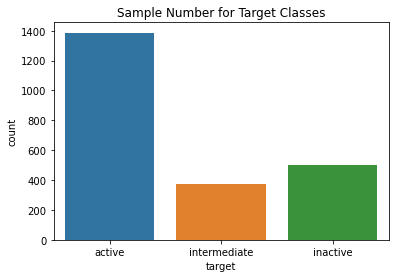

In [13]:
# Visualize the target class counts
sns.countplot(mmp_basic['target'])
plt.title('Sample Number for Target Classes')
plt.show()

Combining the inactive and intermediate classes into a not active class would create a fairly balanced dataset (61% active). Deleting the intermediates as the Data Professor does would make it more unbalanced (73% active)

In [21]:
# Save this dataset to CSV
mmp_basic.to_csv('datasets/mmp_basic.csv', index=False)

In [14]:
mmp_basic = pd.read_csv('datasets/mmp_basic.csv')

In [15]:
# The '.' in some SMILES notations indicates a disconnected structure, usually a salt.
# First look at the 'canonical_smiles' that contain '.'s
[x for x in mmp_basic['canonical_smiles'] if '.' in x]

['COc1ccc(S(=O)(=O)N(Cc2cccnc2)[C@@H](C(=O)NO)C(C)C)cc1.Cl',
 'COc1ccc(S(=O)(=O)N2CCCNCC2C(=O)NO)cc1.Cl',
 'COc1ccc(S(=O)(=O)N2CCCN(C(=O)CN)CC2C(=O)NO)cc1.Cl',
 'Cl.O=C(c1ccncc1)c1ccc(S(=O)(=O)CC(CCCc2ccccc2)C(=O)NO)cc1',
 'CCOP(=O)([O-])C(=O)NC1CCCCC1.[Li+]',
 'CC(C)CNC(=O)P(=O)(O)O.NC1CCCCC1',
 'CC(C)CCNC(=O)P(=O)(O)O.NC1CCCCC1',
 'CCCCNC(=O)P(=O)([O-])O.[Na+]',
 'Cl.O=C(NO)[C@H]1CC(OC(=O)N2CCCC2)CN[C@@H]1C(=O)N1CC[C@H](c2ccccc2)C1',
 'Cl.Nc1ccc(Oc2ccc(S(=O)(=O)C[C@@H]3CS3)cc2)cc1',
 'Cl.Nc1ccc(Oc2ccc(S(=O)(=O)C[C@H]3CS3)cc2)cc1',
 'Cl.Nc1ccc(Oc2ccc(S(=O)(=O)CC3CS3)cc2)cc1']

In [16]:
# These are not part of the chemical structure, so will remove them

for i, x in enumerate(mmp_basic['canonical_smiles']):
    # Split the smiles on the '.'
    smiles = x.split('.')
    # Save the longer piece of the split to the 'canonical_smiles' column
    mmp_basic.loc[i, 'canonical_smiles'] = max(smiles, key=len)
    
mmp_basic.head()

,molecule_chembl_id,canonical_smiles,standard_value,target
0,CHEMBL80814,COc1ccc(CCN2CCC(C(=O)NO)(S(=O)(=O)c3ccc(OC)cc3...,34.00,active
1,CHEMBL276119,COc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(Cc3cccc(OC)c3)...,9.00,active
2,CHEMBL78934,CCCCOc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(Cc3ccc(Cl)c...,20.00,active
3,CHEMBL78369,O=C(NO)C1(S(=O)(=O)c2ccc(OCc3ccccc3)cc2)CCN(Cc...,3.00,active
4,CHEMBL514138,COc1ccc(S(=O)(=O)N(Cc2cccnc2)[C@@H](C(=O)NO)C(...,9.00,active


In [17]:
# Check that there are no longer any salts in the data
[x for x in mmp_basic['canonical_smiles'] if '.' in x]

[]

### Data exploration

This section is an exploration of the compounds and their 'druglikeness' as explained below. I will compare the 3 target classes to see if they have similar pharmacokinetic profiles. 

*** From Data Professor notebook ***
Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the druglikeness of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the Rule-of-Five or Lipinski's Rule.

The Lipinski's Rule stated the following:

- Molecular weight < 500 Dalton
- Octanol-water partition coefficient (LogP) < 5
- Hydrogen bond donors < 5
- Hydrogen bond acceptors < 10

In [18]:
# Calculate the Rule-of-Five for compounds in the dataset

for i, x in enumerate(mmp_basic['canonical_smiles']):
    # Create Molecule object from the canonical smiles
    mol = Chem.MolFromSmiles(x)
    # Calculate and add column for the molecular weight
    mmp_basic.loc[i, 'mol_wt'] = Descriptors.MolWt(mol)
    # Calculate and add column for the LogP
    mmp_basic.loc[i, 'mol_logp'] = Descriptors.MolLogP(mol)
    # Calculate and add column for the number of Hydrogen bond donors
    mmp_basic.loc[i, 'num_H_don'] = Descriptors.NumHDonors(mol)
    # Calculate and add column for the number of Hydrogen bond acceptors
    mmp_basic.loc[i, 'num_H_acpt'] = Descriptors.NumHAcceptors(mol)
   
mmp_basic.head()

,molecule_chembl_id,canonical_smiles,standard_value,target,mol_wt,mol_logp,num_H_don,num_H_acpt
0,CHEMBL80814,COc1ccc(CCN2CCC(C(=O)NO)(S(=O)(=O)c3ccc(OC)cc3...,34.00,active,448.54,2.06,2.00,7.00
1,CHEMBL276119,COc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(Cc3cccc(OC)c3)...,9.00,active,434.51,2.02,2.00,7.00
2,CHEMBL78934,CCCCOc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(Cc3ccc(Cl)c...,20.00,active,515.46,4.49,2.00,6.00
3,CHEMBL78369,O=C(NO)C1(S(=O)(=O)c2ccc(OCc3ccccc3)cc2)CCN(Cc...,3.00,active,480.59,3.58,2.00,6.00
4,CHEMBL514138,COc1ccc(S(=O)(=O)N(Cc2cccnc2)[C@@H](C(=O)NO)C(...,9.00,active,393.47,1.81,2.00,6.00


In [19]:
# Overall, do the compounds fit the profile for a useful drug?
mmp_basic.describe()

,standard_value,mol_wt,mol_logp,num_H_don,num_H_acpt
count,2263.00,2263.00,2263.00,2263.00,2263.00
mean,14706.53,450.92,2.80,2.51,5.83
std,48163.53,129.86,1.56,1.34,2.20
min,0.00,110.11,-1.25,0.00,1.00
25%,9.20,377.41,1.78,2.00,4.00
50%,191.00,445.61,2.76,2.00,6.00
75%,5881.00,507.55,3.64,3.00,7.00
max,1000000.00,1443.29,10.30,25.00,30.00


Yes- the mean Molecular Weight is below 500, the LogP and number of H donors are below 5 and the number of H acceptors is below 10. Even when looking at the upper quartile line, the features meet are are close to meeting the criteria. 

In [20]:
# Save dataset to csv
mmp_basic.to_csv('datasets/mmp_basic_lipinski.csv')

In [21]:
# Import dataset, view first 5 lines
lipinski = pd.read_csv('datasets/mmp_basic_lipinski.csv')
lipinski.head()

,Unnamed: 0,molecule_chembl_id,canonical_smiles,standard_value,target,mol_wt,mol_logp,num_H_don,num_H_acpt
0,0,CHEMBL80814,COc1ccc(CCN2CCC(C(=O)NO)(S(=O)(=O)c3ccc(OC)cc3...,34.00,active,448.54,2.06,2.00,7.00
1,1,CHEMBL276119,COc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(Cc3cccc(OC)c3)...,9.00,active,434.51,2.02,2.00,7.00
2,2,CHEMBL78934,CCCCOc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(Cc3ccc(Cl)c...,20.00,active,515.46,4.49,2.00,6.00
3,3,CHEMBL78369,O=C(NO)C1(S(=O)(=O)c2ccc(OCc3ccccc3)cc2)CCN(Cc...,3.00,active,480.59,3.58,2.00,6.00
4,4,CHEMBL514138,COc1ccc(S(=O)(=O)N(Cc2cccnc2)[C@@H](C(=O)NO)C(...,9.00,active,393.47,1.81,2.00,6.00


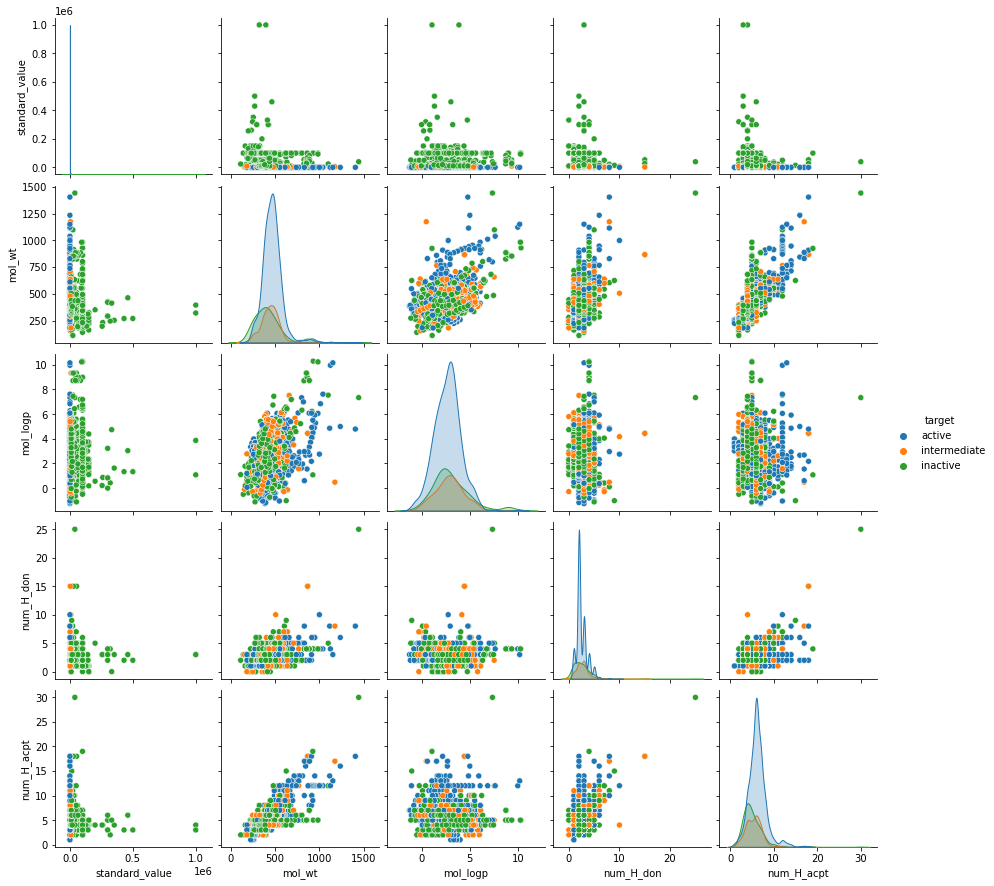

In [31]:
# Are there any patterns distinguishing the target classes in scatterplots
sns.pairplot(mmp_basic, hue='target')

I don't see any clear patterns. 

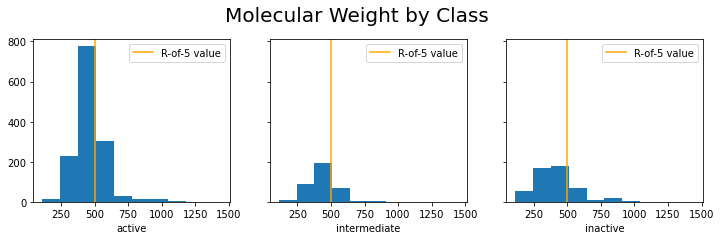


mol_wt: Active vs Inactive
Statistics: 246423.0 of 696274, p:  0.00000, Interpretation: Different distribution (reject H0)
mol_wt: Intermediate vs Inactive
Statistics: 75198.5 of 187748, p:  0.00000, Interpretation: Different distribution (reject H0)
mol_wt: Active vs Intermediate
Statistics: 229890.5 of 518738, p:  0.00037, Interpretation: Different distribution (reject H0)
-----------------------------------------------------------------------------------------------




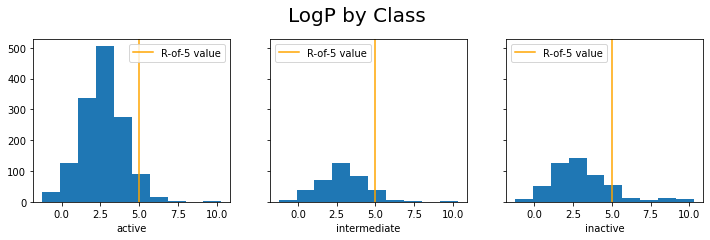


mol_logp: Active vs Inactive
Statistics: 324144.5 of 696274, p:  0.01098, Interpretation: Different distribution (reject H0)
mol_logp: Intermediate vs Inactive
Statistics: 93584.5 of 187748, p:  0.46891, Interpretation: Same distribution (fail to reject H0)
mol_logp: Active vs Intermediate
Statistics: 238645.0 of 518738, p:  0.00879, Interpretation: Different distribution (reject H0)
-----------------------------------------------------------------------------------------------




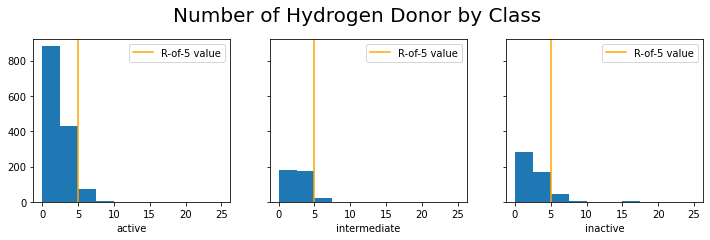


num_H_don: Active vs Inactive
Statistics: 330646.5 of 696274, p:  0.03832, Interpretation: Different distribution (reject H0)
num_H_don: Intermediate vs Inactive
Statistics: 83817.0 of 187748, p:  0.00254, Interpretation: Different distribution (reject H0)
num_H_don: Active vs Intermediate
Statistics: 234975.5 of 518738, p:  0.00135, Interpretation: Different distribution (reject H0)
-----------------------------------------------------------------------------------------------




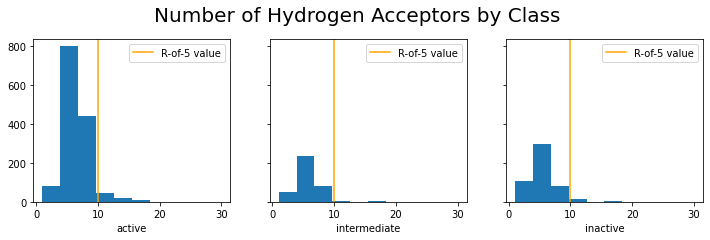


num_H_acpt: Active vs Inactive
Statistics: 219312.5 of 696274, p:  0.00000, Interpretation: Different distribution (reject H0)
num_H_acpt: Intermediate vs Inactive
Statistics: 80210.5 of 187748, p:  0.00009, Interpretation: Different distribution (reject H0)
num_H_acpt: Active vs Intermediate
Statistics: 197061.0 of 518738, p:  0.00000, Interpretation: Different distribution (reject H0)
-----------------------------------------------------------------------------------------------




In [24]:
# What is the distribution of the classes for the various features?

# Define features and classes
columns = mmp_basic.columns[4:]
classes = ['active', 'intermediate', 'inactive']

# Define the Rule-of-Five criteria
lines = {'mol_wt': 500, 'mol_logp': 5, 'num_H_don': 5, 'num_H_acpt':10}
# Create better titles
titles = {'mol_wt': 'Molecular Weight by Class', 
          'mol_logp': 'LogP by Class', 
          'num_H_don': 'Number of Hydrogen Donor by Class', 
          'num_H_acpt': 'Number of Hydrogen Acceptors by Class'}

# Plot distribution of each feature for each class
for column in columns:
    fig, ax = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
    for i in range(3):
        ax[i].hist(mmp_basic[column].loc[mmp_basic['target']==classes[i]],
                   range=(mmp_basic[column].min(), mmp_basic[column].max())) 
        ax[i].set_xlabel(classes[i])
        # Add line to show the Rule-of-Five criteria for each feature
        ax[i].axvline(x=lines.get(column), color='orange', label="R-of-5 value")
        ax[i].legend()
    title = plt.suptitle(titles.get(column), fontsize=20)
    title.set_y(1.03)
    plt.show()
    # Calculate and print Mann Whitney U test statistcs & p-values for
    # each feature for each class pair
    ut.mannwhitney(lipinski, column)
    # Adding whitespace between feature information
    print('-----------------------------------------------------------------------------------------------')
    print()
    print()

The distributions of the logP values and molecular weights for all classes are mostly normal, while the numbers of H acceptors and donors are less normal for all classes. The differences in values for all features between all classes is statistically significant with the exception of the logP values in the intermediate and inactive classes. This indicates that there are distinct pharmacokinetic profiles between the classes. 

### Final Dataset Creation

The last step in data preparation is to create the dataset to use for modeling. I will use the canonical smiles to create a dataset using PaDEL-Descriptor, a software program that will calculate molecular descriptors and fingerprints. 

In [22]:
%%script echo skipping
# Download the software from the Data Professor's GitHub 
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

--2021-06-25 13:10:02--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
Resolving github.com... 140.82.113.3
Connecting to github.com|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip [following]
--2021-06-25 13:10:02--  https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip
Resolving raw.githubusercontent.com... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25768637 (25M) [application/zip]
Saving to: 'padel.zip'

padel.zip           100%[===================>]  24.57M  9.66MB/s    in 2.5s    

2021-06-25 13:10:05 (9.66 MB/s) - 'padel.zip' saved [25768637/25768637]

--2021-06-25 13:10:05--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh
Resolving github.com... 140

In [23]:
%%script echo skipping
# Unzip the software
! unzip padel.zip

Archive:  padel.zip
  inflating: __MACOSX/._PaDEL-Descriptor  
  inflating: PaDEL-Descriptor/MACCSFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._MACCSFingerprinter.xml  
  inflating: PaDEL-Descriptor/AtomPairs2DFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._AtomPairs2DFingerprinter.xml  
  inflating: PaDEL-Descriptor/EStateFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._EStateFingerprinter.xml  
  inflating: PaDEL-Descriptor/Fingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._Fingerprinter.xml  
  inflating: PaDEL-Descriptor/.DS_Store  
  inflating: __MACOSX/PaDEL-Descriptor/._.DS_Store  
  inflating: __MACOSX/PaDEL-Descriptor/._license  
  inflating: PaDEL-Descriptor/KlekotaRothFingerprintCount.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._KlekotaRothFingerprintCount.xml  
  inflating: PaDEL-Descriptor/config  
  inflating: __MACOSX/PaDEL-Descriptor/._config  
  inflating: PaDEL-Descriptor/PubchemFingerprinter.xml  
  inflating: __MAC

In [26]:
# Prepare the lipinski dataset to be fed into the program
# The only features needed are the canonical smiles and the ChEMBL ID
selection = ['canonical_smiles','molecule_chembl_id']
for_modeling = lipinski[selection]
# Save the file as the required .smi file type
for_modeling.to_csv('datasets/molecule.smi', sep='\t', index=False, header=False)

In [27]:
# View the first 5 rows in the saved dataset
! cat datasets/molecule.smi | head -5

COc1ccc(CCN2CCC(C(=O)NO)(S(=O)(=O)c3ccc(OC)cc3)CC2)cc1	CHEMBL80814
COc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(Cc3cccc(OC)c3)CC2)cc1	CHEMBL276119
CCCCOc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(Cc3ccc(Cl)c(Cl)c3)CC2)cc1	CHEMBL78934
O=C(NO)C1(S(=O)(=O)c2ccc(OCc3ccccc3)cc2)CCN(Cc2ccccc2)CC1	CHEMBL78369
COc1ccc(S(=O)(=O)N(Cc2cccnc2)[C@@H](C(=O)NO)C(C)C)cc1	CHEMBL514138
cat: stdout: Broken pipe


In [22]:
# Check that the new dataset contains the same number of rows
# Number of rows in the previous DataFrame
len(lipinski)

2263

In [23]:
# Number of rows in the .smi file
! cat datasets/molecule.smi | wc -l

    2263


In [29]:
# Look at file information
! cat padel.sh

java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv


This shows the settings that will be used to create the dataset; the descriptors will be the PubChem fingerprints and the dataset will be saved as 'descriptors_output.csv'

In [25]:
%%script echo skipping
# Use PaDEL to create the dataset of PubChem fingerprints 
! bash padel.sh

Processing CHEMBL80814 in molecule.smi (1/2263). 
Processing CHEMBL276119 in molecule.smi (2/2263). 
Processing CHEMBL78934 in molecule.smi (3/2263). 
Processing CHEMBL78369 in molecule.smi (4/2263). 
Processing CHEMBL514138 in molecule.smi (5/2263). Average speed: 5.92 s/mol.
Processing CHEMBL80453 in molecule.smi (6/2263). Average speed: 3.06 s/mol.
Processing CHEMBL312432 in molecule.smi (7/2263). Average speed: 2.08 s/mol.
Processing CHEMBL306617 in molecule.smi (8/2263). Average speed: 1.89 s/mol.
Processing CHEMBL79111 in molecule.smi (9/2263). Average speed: 1.57 s/mol.
Processing CHEMBL78798 in molecule.smi (10/2263). Average speed: 1.37 s/mol.
Processing CHEMBL80969 in molecule.smi (11/2263). Average speed: 1.29 s/mol.
Processing CHEMBL78909 in molecule.smi (12/2263). Average speed: 1.21 s/mol.
Processing CHEMBL76137 in molecule.smi (13/2263). Average speed: 1.23 s/mol.
Processing CHEMBL310340 in molecule.smi (14/2263). Average speed: 1.15 s/mol.
Processing CHEMBL440498 in mol

Processing CHEMBL80300 in molecule.smi (108/2263). Average speed: 0.36 s/mol.
Processing CHEMBL310655 in molecule.smi (109/2263). Average speed: 0.36 s/mol.
Processing CHEMBL308305 in molecule.smi (110/2263). Average speed: 0.36 s/mol.
Processing CHEMBL80894 in molecule.smi (111/2263). Average speed: 0.36 s/mol.
Processing CHEMBL90978 in molecule.smi (112/2263). Average speed: 0.36 s/mol.
Processing CHEMBL80322 in molecule.smi (113/2263). Average speed: 0.36 s/mol.
Processing CHEMBL76974 in molecule.smi (114/2263). Average speed: 0.36 s/mol.
Processing CHEMBL101121 in molecule.smi (115/2263). Average speed: 0.35 s/mol.
Processing CHEMBL297792 in molecule.smi (116/2263). Average speed: 0.35 s/mol.
Processing CHEMBL103442 in molecule.smi (117/2263). Average speed: 0.35 s/mol.
Processing CHEMBL155874 in molecule.smi (118/2263). Average speed: 0.35 s/mol.
Processing CHEMBL160461 in molecule.smi (119/2263). Average speed: 0.35 s/mol.
Processing CHEMBL160153 in molecule.smi (121/2263). Avera

Processing CHEMBL18943 in molecule.smi (213/2263). Average speed: 0.29 s/mol.
Processing CHEMBL305722 in molecule.smi (214/2263). Average speed: 0.29 s/mol.
Processing CHEMBL80565 in molecule.smi (215/2263). Average speed: 0.28 s/mol.
Processing CHEMBL3085155 in molecule.smi (216/2263). Average speed: 0.28 s/mol.
Processing CHEMBL310338 in molecule.smi (217/2263). Average speed: 0.28 s/mol.
Processing CHEMBL76356 in molecule.smi (218/2263). Average speed: 0.28 s/mol.
Processing CHEMBL18667 in molecule.smi (219/2263). Average speed: 0.28 s/mol.
Processing CHEMBL310688 in molecule.smi (220/2263). Average speed: 0.28 s/mol.
Processing CHEMBL80496 in molecule.smi (221/2263). Average speed: 0.28 s/mol.
Processing CHEMBL94363 in molecule.smi (222/2263). Average speed: 0.28 s/mol.
Processing CHEMBL278060 in molecule.smi (223/2263). Average speed: 0.28 s/mol.
Processing CHEMBL76619 in molecule.smi (224/2263). Average speed: 0.28 s/mol.
Processing CHEMBL19005 in molecule.smi (225/2263). Average

Processing CHEMBL366956 in molecule.smi (318/2263). Average speed: 0.24 s/mol.
Processing CHEMBL174641 in molecule.smi (319/2263). Average speed: 0.24 s/mol.
Processing CHEMBL176832 in molecule.smi (320/2263). Average speed: 0.24 s/mol.
Processing CHEMBL177740 in molecule.smi (321/2263). Average speed: 0.24 s/mol.
Processing CHEMBL176876 in molecule.smi (322/2263). Average speed: 0.24 s/mol.
Processing CHEMBL173075 in molecule.smi (323/2263). Average speed: 0.24 s/mol.
Processing CHEMBL176467 in molecule.smi (324/2263). Average speed: 0.24 s/mol.
Processing CHEMBL329617 in molecule.smi (325/2263). Average speed: 0.24 s/mol.
Processing CHEMBL367524 in molecule.smi (326/2263). Average speed: 0.24 s/mol.
Processing CHEMBL303666 in molecule.smi (327/2263). Average speed: 0.24 s/mol.
Processing CHEMBL432842 in molecule.smi (328/2263). Average speed: 0.24 s/mol.
Processing CHEMBL19623 in molecule.smi (329/2263). Average speed: 0.24 s/mol.
Processing CHEMBL279078 in molecule.smi (330/2263). A

Processing CHEMBL48039 in molecule.smi (423/2263). Average speed: 0.23 s/mol.
Processing CHEMBL53840 in molecule.smi (424/2263). Average speed: 0.23 s/mol.
Processing CHEMBL58546 in molecule.smi (425/2263). Average speed: 0.23 s/mol.
Processing CHEMBL337042 in molecule.smi (426/2263). Average speed: 0.23 s/mol.
Processing CHEMBL134849 in molecule.smi (427/2263). Average speed: 0.23 s/mol.
Processing CHEMBL36999 in molecule.smi (428/2263). Average speed: 0.23 s/mol.
Processing CHEMBL291490 in molecule.smi (429/2263). Average speed: 0.23 s/mol.
Processing CHEMBL54176 in molecule.smi (430/2263). Average speed: 0.23 s/mol.
Processing CHEMBL59423 in molecule.smi (431/2263). Average speed: 0.23 s/mol.
Processing CHEMBL339381 in molecule.smi (432/2263). Average speed: 0.22 s/mol.
Processing CHEMBL296327 in molecule.smi (433/2263). Average speed: 0.23 s/mol.
Processing CHEMBL57551 in molecule.smi (434/2263). Average speed: 0.22 s/mol.
Processing CHEMBL36191 in molecule.smi (435/2263). Average 

Processing CHEMBL287632 in molecule.smi (528/2263). Average speed: 0.21 s/mol.
Processing CHEMBL311266 in molecule.smi (529/2263). Average speed: 0.21 s/mol.
Processing CHEMBL97034 in molecule.smi (530/2263). Average speed: 0.21 s/mol.
Processing CHEMBL96438 in molecule.smi (531/2263). Average speed: 0.21 s/mol.
Processing CHEMBL327262 in molecule.smi (532/2263). Average speed: 0.21 s/mol.
Processing CHEMBL421131 in molecule.smi (533/2263). Average speed: 0.21 s/mol.
Processing CHEMBL97709 in molecule.smi (534/2263). Average speed: 0.21 s/mol.
Processing CHEMBL329145 in molecule.smi (535/2263). Average speed: 0.21 s/mol.
Processing CHEMBL7390 in molecule.smi (536/2263). Average speed: 0.21 s/mol.
Processing CHEMBL424407 in molecule.smi (537/2263). Average speed: 0.21 s/mol.
Processing CHEMBL27408 in molecule.smi (538/2263). Average speed: 0.21 s/mol.
Processing CHEMBL83616 in molecule.smi (539/2263). Average speed: 0.21 s/mol.
Processing CHEMBL92512 in molecule.smi (540/2263). Average 

Processing CHEMBL349800 in molecule.smi (633/2263). Average speed: 0.21 s/mol.
Processing CHEMBL2112477 in molecule.smi (634/2263). Average speed: 0.21 s/mol.
Processing CHEMBL158571 in molecule.smi (635/2263). Average speed: 0.21 s/mol.
Processing CHEMBL352231 in molecule.smi (636/2263). Average speed: 0.21 s/mol.
Processing CHEMBL158823 in molecule.smi (637/2263). Average speed: 0.21 s/mol.
Processing CHEMBL347249 in molecule.smi (638/2263). Average speed: 0.20 s/mol.
Processing CHEMBL161562 in molecule.smi (639/2263). Average speed: 0.21 s/mol.
Processing CHEMBL436623 in molecule.smi (640/2263). Average speed: 0.21 s/mol.
Processing CHEMBL159033 in molecule.smi (641/2263). Average speed: 0.21 s/mol.
Processing CHEMBL345640 in molecule.smi (643/2263). Average speed: 0.21 s/mol.
Processing CHEMBL345244 in molecule.smi (642/2263). Average speed: 0.21 s/mol.
Processing CHEMBL162128 in molecule.smi (645/2263). Average speed: 0.21 s/mol.
Processing CHEMBL158366 in molecule.smi (644/2263).

Processing CHEMBL75302 in molecule.smi (738/2263). Average speed: 0.20 s/mol.
Processing CHEMBL307915 in molecule.smi (739/2263). Average speed: 0.20 s/mol.
Processing CHEMBL75139 in molecule.smi (740/2263). Average speed: 0.20 s/mol.
Processing CHEMBL77874 in molecule.smi (741/2263). Average speed: 0.20 s/mol.
Processing CHEMBL75164 in molecule.smi (742/2263). Average speed: 0.20 s/mol.
Processing CHEMBL73652 in molecule.smi (743/2263). Average speed: 0.20 s/mol.
Processing CHEMBL275654 in molecule.smi (744/2263). Average speed: 0.20 s/mol.
Processing CHEMBL319887 in molecule.smi (746/2263). Average speed: 0.20 s/mol.
Processing CHEMBL100134 in molecule.smi (745/2263). Average speed: 0.20 s/mol.
Processing CHEMBL102057 in molecule.smi (747/2263). Average speed: 0.20 s/mol.
Processing CHEMBL99745 in molecule.smi (748/2263). Average speed: 0.20 s/mol.
Processing CHEMBL101612 in molecule.smi (749/2263). Average speed: 0.20 s/mol.
Processing CHEMBL100564 in molecule.smi (750/2263). Averag

Processing CHEMBL379247 in molecule.smi (842/2263). Average speed: 0.22 s/mol.
Processing CHEMBL201298 in molecule.smi (843/2263). Average speed: 0.22 s/mol.
Processing CHEMBL202875 in molecule.smi (844/2263). Average speed: 0.22 s/mol.
Processing CHEMBL204593 in molecule.smi (845/2263). Average speed: 0.22 s/mol.
Processing CHEMBL378740 in molecule.smi (846/2263). Average speed: 0.22 s/mol.
Processing CHEMBL211037 in molecule.smi (847/2263). Average speed: 0.22 s/mol.
Processing CHEMBL206045 in molecule.smi (848/2263). Average speed: 0.22 s/mol.
Processing CHEMBL209465 in molecule.smi (849/2263). Average speed: 0.22 s/mol.
Processing CHEMBL377112 in molecule.smi (850/2263). Average speed: 0.22 s/mol.
Processing CHEMBL207026 in molecule.smi (851/2263). Average speed: 0.22 s/mol.
Processing CHEMBL211036 in molecule.smi (853/2263). Average speed: 0.22 s/mol.
Processing CHEMBL208615 in molecule.smi (852/2263). Average speed: 0.22 s/mol.
Processing CHEMBL379220 in molecule.smi (854/2263). 

Processing CHEMBL228188 in molecule.smi (946/2263). Average speed: 0.22 s/mol.
Processing CHEMBL228187 in molecule.smi (947/2263). Average speed: 0.22 s/mol.
Processing CHEMBL227484 in molecule.smi (948/2263). Average speed: 0.22 s/mol.
Processing CHEMBL376557 in molecule.smi (949/2263). Average speed: 0.22 s/mol.
Processing CHEMBL374377 in molecule.smi (950/2263). Average speed: 0.22 s/mol.
Processing CHEMBL227598 in molecule.smi (951/2263). Average speed: 0.22 s/mol.
Processing CHEMBL227824 in molecule.smi (952/2263). Average speed: 0.22 s/mol.
Processing CHEMBL228231 in molecule.smi (953/2263). Average speed: 0.22 s/mol.
Processing CHEMBL388309 in molecule.smi (954/2263). Average speed: 0.22 s/mol.
Processing CHEMBL228230 in molecule.smi (955/2263). Average speed: 0.22 s/mol.
Processing CHEMBL228229 in molecule.smi (956/2263). Average speed: 0.22 s/mol.
Processing CHEMBL227566 in molecule.smi (957/2263). Average speed: 0.21 s/mol.
Processing CHEMBL226149 in molecule.smi (958/2263). 

Processing CHEMBL252523 in molecule.smi (1050/2263). Average speed: 0.21 s/mol.
Processing CHEMBL252522 in molecule.smi (1051/2263). Average speed: 0.21 s/mol.
Processing CHEMBL402720 in molecule.smi (1052/2263). Average speed: 0.21 s/mol.
Processing CHEMBL442286 in molecule.smi (1053/2263). Average speed: 0.21 s/mol.
Processing CHEMBL252327 in molecule.smi (1054/2263). Average speed: 0.21 s/mol.
Processing CHEMBL404205 in molecule.smi (1055/2263). Average speed: 0.21 s/mol.
Processing CHEMBL252326 in molecule.smi (1056/2263). Average speed: 0.21 s/mol.
Processing CHEMBL254821 in molecule.smi (1057/2263). Average speed: 0.21 s/mol.
Processing CHEMBL398838 in molecule.smi (1058/2263). Average speed: 0.21 s/mol.
Processing CHEMBL254039 in molecule.smi (1059/2263). Average speed: 0.21 s/mol.
Processing CHEMBL254038 in molecule.smi (1060/2263). Average speed: 0.21 s/mol.
Processing CHEMBL253835 in molecule.smi (1061/2263). Average speed: 0.21 s/mol.
Processing CHEMBL253189 in molecule.smi 

Processing CHEMBL252022 in molecule.smi (1153/2263). Average speed: 0.20 s/mol.
Processing CHEMBL252021 in molecule.smi (1154/2263). Average speed: 0.20 s/mol.
Processing CHEMBL252020 in molecule.smi (1155/2263). Average speed: 0.20 s/mol.
Processing CHEMBL251821 in molecule.smi (1156/2263). Average speed: 0.20 s/mol.
Processing CHEMBL401404 in molecule.smi (1157/2263). Average speed: 0.20 s/mol.
Processing CHEMBL399566 in molecule.smi (1158/2263). Average speed: 0.20 s/mol.
Processing CHEMBL254506 in molecule.smi (1159/2263). Average speed: 0.20 s/mol.
Processing CHEMBL399565 in molecule.smi (1160/2263). Average speed: 0.20 s/mol.
Processing CHEMBL254293 in molecule.smi (1161/2263). Average speed: 0.20 s/mol.
Processing CHEMBL400785 in molecule.smi (1162/2263). Average speed: 0.20 s/mol.
Processing CHEMBL400784 in molecule.smi (1163/2263). Average speed: 0.20 s/mol.
Processing CHEMBL400193 in molecule.smi (1164/2263). Average speed: 0.20 s/mol.
Processing CHEMBL400192 in molecule.smi 

Processing CHEMBL497985 in molecule.smi (1256/2263). Average speed: 0.20 s/mol.
Processing CHEMBL491643 in molecule.smi (1257/2263). Average speed: 0.20 s/mol.
Processing CHEMBL523034 in molecule.smi (1258/2263). Average speed: 0.20 s/mol.
Processing CHEMBL455409 in molecule.smi (1259/2263). Average speed: 0.20 s/mol.
Processing CHEMBL460899 in molecule.smi (1261/2263). Average speed: 0.20 s/mol.
Processing CHEMBL460725 in molecule.smi (1260/2263). Average speed: 0.20 s/mol.
Processing CHEMBL180239 in molecule.smi (1262/2263). Average speed: 0.20 s/mol.
Processing CHEMBL116438 in molecule.smi (1263/2263). Average speed: 0.20 s/mol.
Processing CHEMBL481600 in molecule.smi (1264/2263). Average speed: 0.20 s/mol.
Processing CHEMBL473326 in molecule.smi (1266/2263). Average speed: 0.20 s/mol.
Processing CHEMBL481599 in molecule.smi (1265/2263). Average speed: 0.20 s/mol.
Processing CHEMBL500351 in molecule.smi (1267/2263). Average speed: 0.20 s/mol.
Processing CHEMBL448246 in molecule.smi 

Processing CHEMBL1090035 in molecule.smi (1359/2263). Average speed: 0.20 s/mol.
Processing CHEMBL1090284 in molecule.smi (1360/2263). Average speed: 0.20 s/mol.
Processing CHEMBL1090647 in molecule.smi (1361/2263). Average speed: 0.20 s/mol.
Processing CHEMBL1093689 in molecule.smi (1362/2263). Average speed: 0.20 s/mol.
Processing CHEMBL1093690 in molecule.smi (1363/2263). Average speed: 0.20 s/mol.
Processing CHEMBL1092104 in molecule.smi (1364/2263). Average speed: 0.20 s/mol.
Processing CHEMBL1089842 in molecule.smi (1365/2263). Average speed: 0.20 s/mol.
Processing CHEMBL1089843 in molecule.smi (1366/2263). Average speed: 0.20 s/mol.
Processing CHEMBL1088878 in molecule.smi (1367/2263). Average speed: 0.20 s/mol.
Processing CHEMBL1085602 in molecule.smi (1368/2263). Average speed: 0.20 s/mol.
Processing CHEMBL1082966 in molecule.smi (1369/2263). Average speed: 0.20 s/mol.
Processing CHEMBL1083906 in molecule.smi (1370/2263). Average speed: 0.20 s/mol.
Processing CHEMBL1083907 in 

Processing CHEMBL1801419 in molecule.smi (1461/2263). Average speed: 0.20 s/mol.
Processing CHEMBL1801418 in molecule.smi (1462/2263). Average speed: 0.20 s/mol.
Processing CHEMBL1801417 in molecule.smi (1463/2263). Average speed: 0.20 s/mol.
Processing CHEMBL1801415 in molecule.smi (1464/2263). Average speed: 0.20 s/mol.
Processing CHEMBL1801413 in molecule.smi (1465/2263). Average speed: 0.20 s/mol.
Processing CHEMBL1801057 in molecule.smi (1466/2263). Average speed: 0.20 s/mol.
Processing CHEMBL1801056 in molecule.smi (1467/2263). Average speed: 0.20 s/mol.
Processing CHEMBL1801054 in molecule.smi (1468/2263). Average speed: 0.20 s/mol.
Processing CHEMBL1801053 in molecule.smi (1469/2263). Average speed: 0.20 s/mol.
Processing CHEMBL1801052 in molecule.smi (1470/2263). Average speed: 0.20 s/mol.
Processing CHEMBL1801051 in molecule.smi (1472/2263). Average speed: 0.20 s/mol.
Processing CHEMBL1229868 in molecule.smi (1471/2263). Average speed: 0.20 s/mol.
Processing CHEMBL1801050 in 

Processing CHEMBL1916398 in molecule.smi (1563/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1935291 in molecule.smi (1564/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1933865 in molecule.smi (1565/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1933882 in molecule.smi (1566/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1939844 in molecule.smi (1567/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1939845 in molecule.smi (1568/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1939846 in molecule.smi (1569/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1939876 in molecule.smi (1570/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1940315 in molecule.smi (1571/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1940308 in molecule.smi (1572/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1940296 in molecule.smi (1573/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1796298 in molecule.smi (1574/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1940316 in 

Processing CHEMBL2151356 in molecule.smi (1665/2263). Average speed: 0.20 s/mol.
Processing CHEMBL2151357 in molecule.smi (1666/2263). Average speed: 0.20 s/mol.
Processing CHEMBL2151358 in molecule.smi (1667/2263). Average speed: 0.20 s/mol.
Processing CHEMBL2151359 in molecule.smi (1668/2263). Average speed: 0.20 s/mol.
Processing CHEMBL2151360 in molecule.smi (1669/2263). Average speed: 0.20 s/mol.
Processing CHEMBL2151361 in molecule.smi (1670/2263). Average speed: 0.20 s/mol.
Processing CHEMBL2151362 in molecule.smi (1671/2263). Average speed: 0.20 s/mol.
Processing CHEMBL2151363 in molecule.smi (1672/2263). Average speed: 0.20 s/mol.
Processing CHEMBL2151364 in molecule.smi (1673/2263). Average speed: 0.20 s/mol.
Processing CHEMBL2151365 in molecule.smi (1674/2263). Average speed: 0.20 s/mol.
Processing CHEMBL2203641 in molecule.smi (1675/2263). Average speed: 0.20 s/mol.
Processing CHEMBL2203640 in molecule.smi (1676/2263). Average speed: 0.20 s/mol.
Processing CHEMBL2203639 in 

Processing CHEMBL1165106 in molecule.smi (1767/2263). Average speed: 0.20 s/mol.
Processing CHEMBL1165241 in molecule.smi (1768/2263). Average speed: 0.20 s/mol.
Processing CHEMBL1165152 in molecule.smi (1769/2263). Average speed: 0.20 s/mol.
Processing CHEMBL1163455 in molecule.smi (1770/2263). Average speed: 0.20 s/mol.
Processing CHEMBL1163454 in molecule.smi (1771/2263). Average speed: 0.20 s/mol.
Processing CHEMBL1165627 in molecule.smi (1772/2263). Average speed: 0.20 s/mol.
Processing CHEMBL69803 in molecule.smi (1773/2263). Average speed: 0.20 s/mol.
Processing CHEMBL68427 in molecule.smi (1774/2263). Average speed: 0.20 s/mol.
Processing CHEMBL421295 in molecule.smi (1775/2263). Average speed: 0.20 s/mol.
Processing CHEMBL67498 in molecule.smi (1776/2263). Average speed: 0.20 s/mol.
Processing CHEMBL67291 in molecule.smi (1777/2263). Average speed: 0.20 s/mol.
Processing CHEMBL275362 in molecule.smi (1778/2263). Average speed: 0.20 s/mol.
Processing CHEMBL323612 in molecule.sm

Processing CHEMBL3098990 in molecule.smi (1869/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3098987 in molecule.smi (1870/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3098985 in molecule.smi (1871/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3099031 in molecule.smi (1872/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3099030 in molecule.smi (1873/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3099029 in molecule.smi (1874/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3099028 in molecule.smi (1875/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3099020 in molecule.smi (1876/2263). Average speed: 0.19 s/mol.
Processing CHEMBL87223 in molecule.smi (1877/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3221177 in molecule.smi (1878/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3221178 in molecule.smi (1879/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3221179 in molecule.smi (1880/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3221863 in mo

Processing CHEMBL3752826 in molecule.smi (1971/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3754302 in molecule.smi (1972/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3751997 in molecule.smi (1974/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3754314 in molecule.smi (1973/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3754094 in molecule.smi (1976/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3752419 in molecule.smi (1975/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3753984 in molecule.smi (1977/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3751971 in molecule.smi (1978/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3752374 in molecule.smi (1979/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3754100 in molecule.smi (1980/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3752513 in molecule.smi (1981/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1229516 in molecule.smi (1982/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3770935 in 

Processing CHEMBL4163839 in molecule.smi (2073/2263). Average speed: 0.19 s/mol.
Processing CHEMBL4168477 in molecule.smi (2074/2263). Average speed: 0.19 s/mol.
Processing CHEMBL4169181 in molecule.smi (2075/2263). Average speed: 0.19 s/mol.
Processing CHEMBL4177034 in molecule.smi (2076/2263). Average speed: 0.19 s/mol.
Processing CHEMBL4165747 in molecule.smi (2077/2263). Average speed: 0.19 s/mol.
Processing CHEMBL4173661 in molecule.smi (2078/2263). Average speed: 0.19 s/mol.
Processing CHEMBL4175968 in molecule.smi (2079/2263). Average speed: 0.19 s/mol.
Processing CHEMBL4165348 in molecule.smi (2080/2263). Average speed: 0.19 s/mol.
Processing CHEMBL4172564 in molecule.smi (2081/2263). Average speed: 0.19 s/mol.
Processing CHEMBL4164242 in molecule.smi (2083/2263). Average speed: 0.19 s/mol.
Processing CHEMBL4161914 in molecule.smi (2082/2263). Average speed: 0.19 s/mol.
Processing CHEMBL4172116 in molecule.smi (2084/2263). Average speed: 0.19 s/mol.
Processing CHEMBL4167168 in 

Processing CHEMBL4238489 in molecule.smi (2175/2263). Average speed: 0.20 s/mol.
Processing CHEMBL4249544 in molecule.smi (2176/2263). Average speed: 0.20 s/mol.
Processing CHEMBL4241167 in molecule.smi (2177/2263). Average speed: 0.20 s/mol.
Processing CHEMBL4245382 in molecule.smi (2178/2263). Average speed: 0.20 s/mol.
Processing CHEMBL4291062 in molecule.smi (2179/2263). Average speed: 0.20 s/mol.
Processing CHEMBL4285838 in molecule.smi (2180/2263). Average speed: 0.20 s/mol.
Processing CHEMBL4278980 in molecule.smi (2181/2263). Average speed: 0.20 s/mol.
Processing CHEMBL4289657 in molecule.smi (2182/2263). Average speed: 0.20 s/mol.
Processing CHEMBL4294130 in molecule.smi (2183/2263). Average speed: 0.20 s/mol.
Processing CHEMBL4286237 in molecule.smi (2184/2263). Average speed: 0.20 s/mol.
Processing CHEMBL4290729 in molecule.smi (2185/2263). Average speed: 0.20 s/mol.
Processing CHEMBL4282849 in molecule.smi (2186/2263). Average speed: 0.20 s/mol.
Processing CHEMBL4283171 in 

In [2]:
# Load and view the first 5 rows of the dataset created by PaDEL-Descriptor
df3_X = pd.read_csv('descriptors_output.csv')
df3_X.head()

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL276119,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL80814,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL78934,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL78369,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL514138,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# View summary statistics of new dataset
df3_X.describe()

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
count,2263.00,2263.00,2263.00,2263.00,2263.00,2263.00,2263.00,2263.00,2263.00,2263.00,...,2263.00,2263.00,2263.00,2263.00,2263.00,2263.00,2263.00,2263.00,2263.00,2263.00
mean,1.00,1.00,0.87,0.17,0.00,0.00,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
std,0.00,0.06,0.34,0.38,0.00,0.00,0.00,0.00,0.00,0.02,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Based on the features shown, it seems that many of them are the same for all rows. Will use feature selection to eliminate low variance features after the data is split into train and test sets. 

In [4]:
# The ChEMBL ID is not useful for model training, but I will use it at the end to find the canonical smiles
# Will set it as the index
X=df3_X.set_index('Name')
X.head()

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
Name,,,,,,,,,,,,,,,,,,,,,
CHEMBL276119,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
CHEMBL80814,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
CHEMBL78934,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
CHEMBL78369,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
CHEMBL514138,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Now that my X dataset is ready, I need the y values
# They are in the lipinski dataset I saved earlier
# Load dataset and set y equal to the target feature
lipinski = pd.read_csv('datasets/mmp_basic_lipinski.csv')
y = lipinski['target']

In [6]:
# I want to start with this as a binary classification problem
# Combine the inactive and intermediate classes into the inactive class
y.where(y=='active', 'inactive', inplace=True)
y.value_counts(normalize=True)

active     0.61
inactive   0.39
Name: target, dtype: float64

In [7]:
# I will be trying to predict active compounds,
# so changing 'active' to 1 and 'inactive' to 0
y = y.map({'active':1, 'inactive':0})
y

0       1
1       1
2       1
3       1
4       1
       ..
2258    0
2259    0
2260    0
2261    0
2262    0
Name: target, Length: 2263, dtype: int64

In [8]:
# Separate data into training and testing sets, keeping index for later use
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, X.index, 
                                                                                 test_size=0.2, random_state=12)

In [9]:
# Check number of features in dataset before deleting low variance features
X_train.shape

(1810, 881)

In [10]:
# Delete low variance features 
# Create instance of VarianceThreshold
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))
# Fit the training data
selection.fit(X_train)
# Select only the higher variance features
X_train = X_train[X_train.columns[selection.get_support(indices=True)]]
X_test = X_test[X_test.columns[selection.get_support(indices=True)]]

In [11]:
# Check how many features remain
X_train.shape

(1810, 147)

Deleted 734 low variance features! There is still a relatively large number of features compared to the number of rows. 

## Modeling

### Model Comparison

I will first use the Lazy Predict library to compare different classification model types to see which work best with this dataset.

In [35]:
# Instantiate the LazyClassifier and fit it to the training data
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None, random_state=6)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [00:11<00:00,  2.63it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SVC,0.84,0.82,0.82,0.84,0.69
NuSVC,0.84,0.82,0.82,0.84,0.69
KNeighborsClassifier,0.82,0.80,0.80,0.82,0.26
LGBMClassifier,0.81,0.80,0.80,0.81,0.36
XGBClassifier,0.81,0.79,0.79,0.81,1.30
RandomForestClassifier,0.80,0.79,0.79,0.80,0.55
ExtraTreesClassifier,0.80,0.79,0.79,0.80,0.43
LabelPropagation,0.74,0.76,0.76,0.75,0.13
LabelSpreading,0.74,0.76,0.76,0.74,0.18


The SVM (2 types), KNeighbors and RandomForest classifiers came out ahead. I will try a basic model of each. 

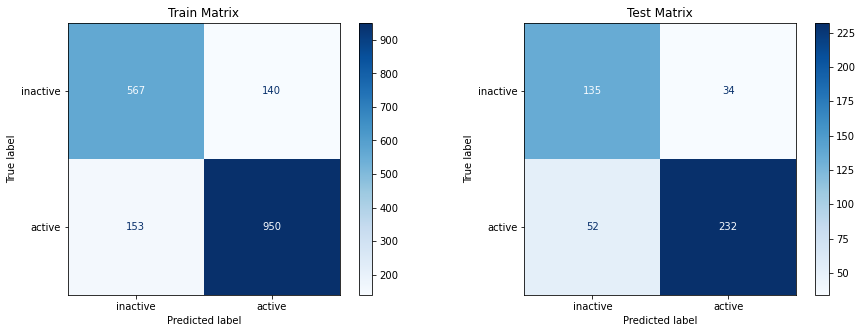

Train scores:
Accuracy:  0.838, ROC/AUC:  0.918
Precision:  0.839, Recall:  0.838, F1 Score:  0.838
Test scores:
Accuracy:  0.810, ROC/AUC:  0.890
Precision:  0.816, Recall:  0.810, F1 Score:  0.812


In [36]:
# Instantiate, fit and evaluate an SVC model
svc = SVC(class_weight='balanced', random_state=6)
svc = svc.fit(X_train, y_train)
ut.evaluate(svc, X_train, X_test, y_train, y_test)

In [12]:
# Create a dataframe to track model results
data =[['SVC_1', 0.838, 0.812, 0.839, 0.816]]

results = pd.DataFrame(data, columns = ['classifier', 
                                        'f1_train', 'f1_test','precision_train', 'precision_test'])
results

,classifier,f1_train,f1_test,precision_train,precision_test
0,SVC_1,0.84,0.81,0.84,0.82


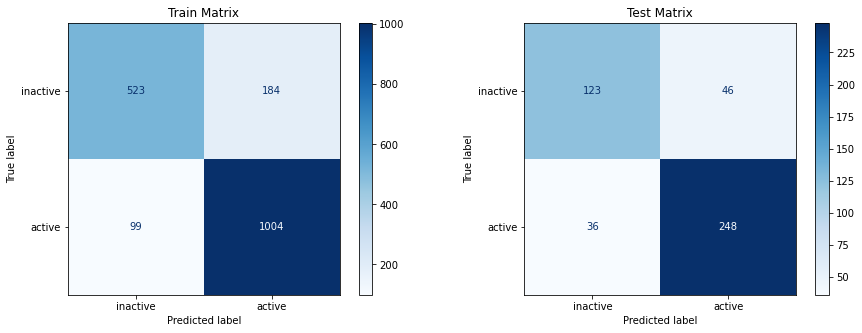

Train scores:
Accuracy:  0.844, ROC/AUC:  0.925
Precision:  0.843, Recall:  0.844, F1 Score:  0.842
Test scores:
Accuracy:  0.819, ROC/AUC:  0.863
Precision:  0.817, Recall:  0.819, F1 Score:  0.818


In [38]:
# Instatiate, fit and evaluate a KNeighbors model
knc = KNeighborsClassifier()
knc = knc.fit(X_train, y_train)
ut.evaluate(knc, X_train, X_test, y_train, y_test, 'no')

In [13]:
# Add results to dataframe
results.loc[len(results.index)] = ['KNC_1', 0.842, 0.818, 0.843, 0.817]
results

,classifier,f1_train,f1_test,precision_train,precision_test
0,SVC_1,0.84,0.81,0.84,0.82
1,KNC_1,0.84,0.82,0.84,0.82


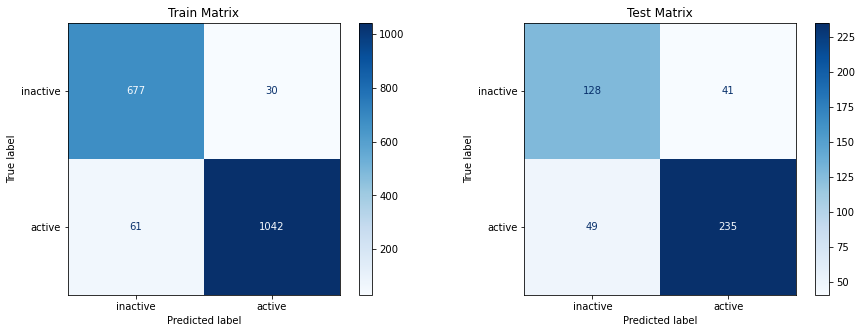

Train scores:
Accuracy:  0.950, ROC/AUC:  0.992
Precision:  0.951, Recall:  0.950, F1 Score:  0.950
Test scores:
Accuracy:  0.801, ROC/AUC:  0.879
Precision:  0.804, Recall:  0.801, F1 Score:  0.802


In [40]:
# Instantiate, fit and evaluate a RandomForest model
rfc = RandomForestClassifier(class_weight='balanced', random_state=6)
rfc = rfc.fit(X_train, y_train)
ut.evaluate(rfc, X_train, X_test, y_train, y_test, 'no')

In [14]:
# Add results to dataframe
results.loc[len(results.index)] = ['RFC_1', 0.950, 0.802, 0.951, 0.804]
results

,classifier,f1_train,f1_test,precision_train,precision_test
0,SVC_1,0.84,0.81,0.84,0.82
1,KNC_1,0.84,0.82,0.84,0.82
2,RFC_1,0.95,0.80,0.95,0.80


I am mainly useing the precision and f1 scores to judge model performance. The purpose of this model is to decrease the number of inactive compounds that are assayed for acvitiy in vitro, so I want to decrease the number of false positives in the model (select a model with a high precision score). Too many false negatives would be bad too, so will look at the f1 score as well. 

The KNeighborsClassifier has the best test scores. The SVC has similar though slightly lower test scores, though it was on top in the Lazy Predict results. The RandomForestClassifier test results were the lowest and also the most overfit.

### Model 1: tune an SVC model

The SVC model was on top of the Lazy Predict results, so I will see if it can be improved with hyper-parameter tuning.

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   23.4s finished


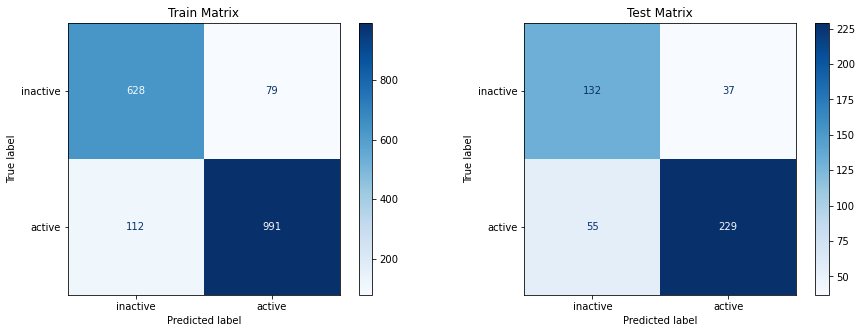

Train scores:
Accuracy:  0.894, ROC/AUC:  0.949
Precision:  0.896, Recall:  0.894, F1 Score:  0.895
Test scores:
Accuracy:  0.797, ROC/AUC:  0.862
Precision:  0.803, Recall:  0.797, F1 Score:  0.799


In [42]:
# Use RandomizedSearch to test a variety of hyperparameters

# Assign hyperparameters to test
C = [0.01, 0.1, 1, 10, 100]
kernel = ['poly', 'rbf', 'sigmoid']
gamma = ['scale', 'auto']
degree = list(range(1, 6))

# Create parameter grid
params = [{'C': C, 'kernel': kernel, 
           'gamma': gamma, 'degree': degree}]

# Instantiate model, run and fit RandomizedSearch, then evaluate the best model
svc_2 = SVC(class_weight='balanced', random_state=6)
rs_svc_2 = RandomizedSearchCV(svc_2, params, scoring='precision_weighted', cv=5, verbose=1, random_state=6)
rs_svc_2.fit(X_train, y_train)
ut.evaluate(rs_svc_2.best_estimator_, X_train, X_test, y_train, y_test)

In [15]:
# Add results to dataframe
results.loc[len(results.index)] = ['RS_SVC_2', 0.895, 0.799, 0.896, 0.803]
results

,classifier,f1_train,f1_test,precision_train,precision_test
0,SVC_1,0.84,0.81,0.84,0.82
1,KNC_1,0.84,0.82,0.84,0.82
2,RFC_1,0.95,0.80,0.95,0.80
3,RS_SVC_2,0.90,0.80,0.90,0.80


Compared to the first SVC model, the train scores have increased, but the test scores decreased.


### Model 2: SVC model removing outliers

In [16]:
# Will eliminating outliers help improve the model fit?

# Use IsolationForest to remove outliers
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(X_train)
# Select all rows that are not outliers
mask = yhat != -1
iso_X, iso_y = X_train[mask, :], y_train[mask]

# Check that it worked & see how many rows were deleted
print(f'Iso X: {iso_X.shape}, y: {iso_y.shape}')
print(f'Train X: {X_train.shape}, y: {y_train.shape}')

Iso X: (1629, 147), y: (1629,)
Train X: (1810, 147), y: (1810,)


181 rows were deleted as outliers (as expected based on the 'contamination' parameter). Will it help the model?

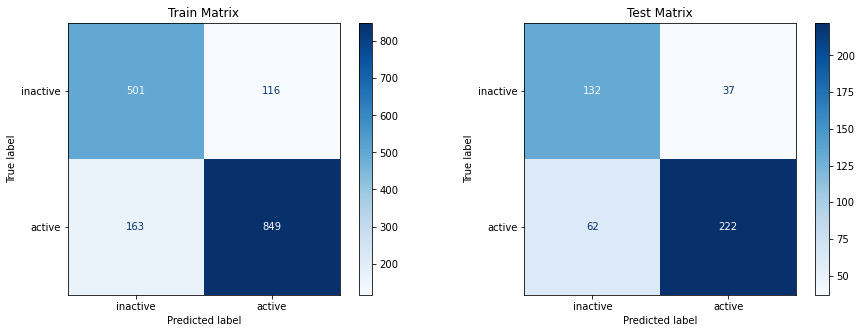

Train scores:
Accuracy:  0.829, ROC/AUC:  0.915
Precision:  0.832, Recall:  0.829, F1 Score:  0.830
Test scores:
Accuracy:  0.781, ROC/AUC:  0.875
Precision:  0.791, Recall:  0.781, F1 Score:  0.784


In [17]:
# Use the data with outliers removed in a basic SVC model
svc_3 = SVC(class_weight='balanced', random_state=6)
svc_3 = svc_3.fit(iso_X, iso_y)
ut.evaluate(svc_3, iso_X, X_test, iso_y, y_test)

In [18]:
# Add results to dataframe
results.loc[len(results.index)] = ['SVC_3-Iso', 0.830, 0.784, 0.832, 0.791]
results

,classifier,f1_train,f1_test,precision_train,precision_test
0,SVC_1,0.84,0.81,0.84,0.82
1,KNC_1,0.84,0.82,0.84,0.82
2,RFC_1,0.95,0.80,0.95,0.80
3,RS_SVC_2,0.90,0.80,0.90,0.80
4,SVC_3-Iso,0.83,0.78,0.83,0.79


Compared to the first SVC model, the train scores have increased, but the test scores decreased again and more significantly. I could try tuning the IsolationForest, but it doesn't seem like it will be productive. So, will try something else-

### Model 3: SVC model with dimensionality reduction

In [19]:
# Too many features can be an issue in SVC
# Will try dimensionality reduction

# Instantiate, fit and transform PCA
pca = PCA()
pca.fit(X_train)
transformed_train = pca.transform(X_train)
transformed_test = pca.transform(X_test)

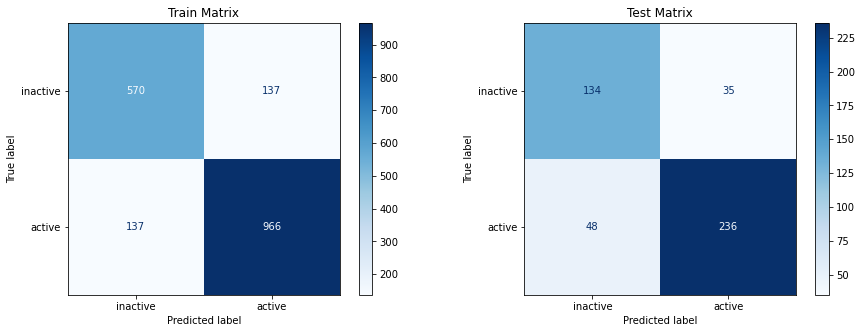

Train scores:
Accuracy:  0.849, ROC/AUC:  0.924
Precision:  0.849, Recall:  0.849, F1 Score:  0.849
Test scores:
Accuracy:  0.817, ROC/AUC:  0.891
Precision:  0.821, Recall:  0.817, F1 Score:  0.818


In [20]:
# Use the PCA transformed data in a basic SVC model
svc_4 = SVC(class_weight='balanced', random_state=6)
svc_4 = svc_4.fit(transformed_train, y_train)
ut.evaluate(svc_4, transformed_train, transformed_test, y_train, y_test)

In [21]:
# Add results to dataframe
results.loc[len(results.index)] = ['SVC_4-PCA', 0.849, 0.818, 0.849, 0.821]
results

,classifier,f1_train,f1_test,precision_train,precision_test
0,SVC_1,0.84,0.81,0.84,0.82
1,KNC_1,0.84,0.82,0.84,0.82
2,RFC_1,0.95,0.80,0.95,0.80
3,RS_SVC_2,0.90,0.80,0.90,0.80
4,SVC_3-Iso,0.83,0.78,0.83,0.79
5,SVC_4-PCA,0.85,0.82,0.85,0.82


This time both the train and test scores increased compared to the first model. Will try to tune using the transformed data to train.

### Model 4: Tune the SVC model with dimensionality reduction

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   23.4s finished


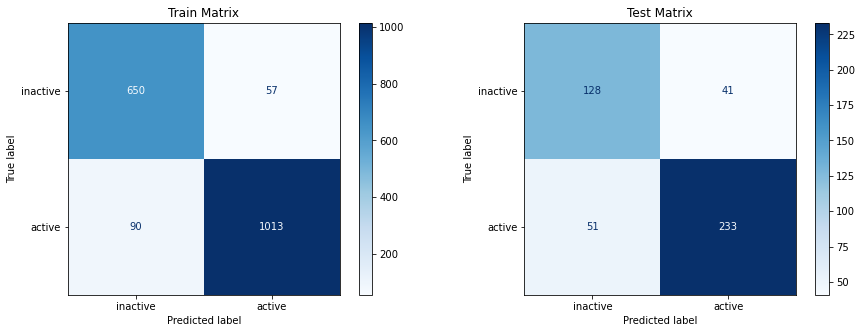

Train scores:
Accuracy:  0.919, ROC/AUC:  0.968
Precision:  0.920, Recall:  0.919, F1 Score:  0.919
Test scores:
Accuracy:  0.797, ROC/AUC:  0.865
Precision:  0.800, Recall:  0.797, F1 Score:  0.798


In [22]:
# Use RandomizedSearch to test a variety of hyperparameters
# Use the transformed_train dataset to train the model

# Assign hyperparameters to test
C = [0.1, 1, 10, 100]
kernel = ['poly', 'rbf', 'sigmoid']
gamma = ['scale', 'auto']
degree = list(range(1, 6))

# Create parameter grid
params = [{'C': C, 'kernel': kernel, 
           'gamma': gamma, 'degree': degree}]

# Instantiate model, run and fit RandomizedSearch, then evaluate the best model
svc_5 = SVC(class_weight='balanced', random_state=6)
rs_svc_5 = RandomizedSearchCV(svc_5, params, scoring='precision_weighted', cv=5, verbose=1, random_state=6)
rs_svc_5.fit(transformed_train, y_train)
ut.evaluate(rs_svc_5.best_estimator_, transformed_train, transformed_test, y_train, y_test)

In [23]:
# Add results to dataframe
results.loc[len(results.index)] = ['RS_SVC_5-PCA', 0.919, 0.798, 0.920, 0.800]
results

,classifier,f1_train,f1_test,precision_train,precision_test
0,SVC_1,0.84,0.81,0.84,0.82
1,KNC_1,0.84,0.82,0.84,0.82
2,RFC_1,0.95,0.80,0.95,0.80
3,RS_SVC_2,0.90,0.80,0.90,0.80
4,SVC_3-Iso,0.83,0.78,0.83,0.79
5,SVC_4-PCA,0.85,0.82,0.85,0.82
6,RS_SVC_5-PCA,0.92,0.80,0.92,0.80


Compared to the first model with PCA tranformed data, the train scores have increased, but the test scores decreased. The basic SVC model with PCA transformed data is the best scoring SVC model that I was able to create.

### Model 5: Tune the KNeighborsClassifier- RandomizedSearch

The KNeighbors Classifier performed the best in my initial test. Can I improve on the basic model?

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    8.5s finished


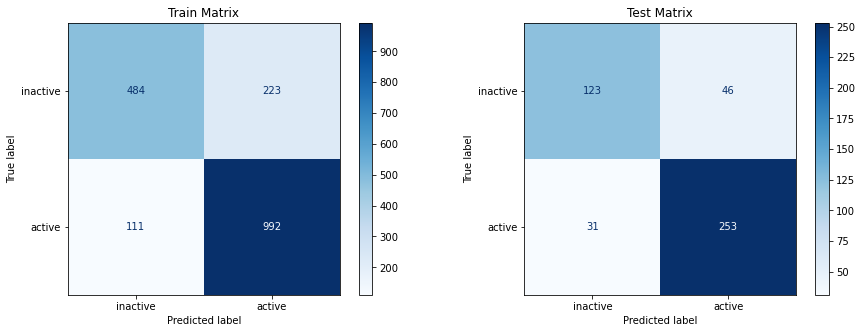

Train scores:
Accuracy:  0.815, ROC/AUC:  0.901
Precision:  0.815, Recall:  0.815, F1 Score:  0.812
Test scores:
Accuracy:  0.830, ROC/AUC:  0.874
Precision:  0.828, Recall:  0.830, F1 Score:  0.828


In [24]:
# Use RandomizedSearch to test a variety of hyperparameters

# Assign hyperparameters to test
metric = ['minkowski', 'manhattan', 'euclidean']
n_neighbors = list(range(1, 31))
leaf_size = list(range(1, 51))
p = [1,2]
weights = ['uniform', 'distance']

# Create parameter grid
params = [{'metric': metric, 'n_neighbors': n_neighbors, 
           'leaf_size': leaf_size, 'p': p, 'weights': weights}]

# Instantiate model, run and fit RandomizedSearch, then evaluate the best model
knc_2 = KNeighborsClassifier()
rs_knc_2 = RandomizedSearchCV(knc_2, params, scoring='precision_weighted', cv=5, verbose=1, random_state=6)
rs_knc_2.fit(X_train, y_train)
ut.evaluate(rs_knc_2.best_estimator_, X_train, X_test, y_train, y_test, 'no')

In [25]:
# Add results to dataframe
results.loc[len(results.index)] = ['RS_KNC_2', 0.812, 0.828, 0.815, 0.828]
results

,classifier,f1_train,f1_test,precision_train,precision_test
0,SVC_1,0.84,0.81,0.84,0.82
1,KNC_1,0.84,0.82,0.84,0.82
2,RFC_1,0.95,0.80,0.95,0.80
3,RS_SVC_2,0.90,0.80,0.90,0.80
4,SVC_3-Iso,0.83,0.78,0.83,0.79
5,SVC_4-PCA,0.85,0.82,0.85,0.82
6,RS_SVC_5-PCA,0.92,0.80,0.92,0.80
7,RS_KNC_2,0.81,0.83,0.81,0.83


In [26]:
# Check what parameters were found to be best
rs_knc_2.best_params_

{'weights': 'uniform',
 'p': 1,
 'n_neighbors': 9,
 'metric': 'minkowski',
 'leaf_size': 50}

The test scores for the best model that the RandomizedSearch was able to find are better than the basic model, though the train scores decrease to be slightly worse than the test scores. 

### Model 6: Tune the KNeighborsClassifier- GridSearch

Will try a GridSearch using the results of the RandomizedSearch to see if the hyperparameters can be tuned a bit more.

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:   16.4s finished


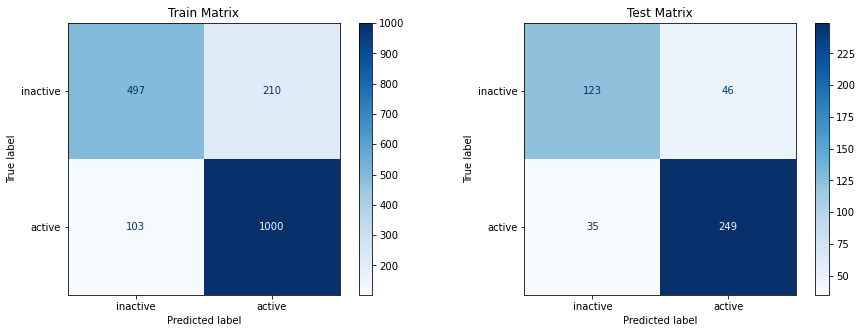

Train scores:
Accuracy:  0.827, ROC/AUC:  0.911
Precision:  0.827, Recall:  0.827, F1 Score:  0.824
Test scores:
Accuracy:  0.821, ROC/AUC:  0.869
Precision:  0.820, Recall:  0.821, F1 Score:  0.820


In [27]:
# Use GridSearch to test a variety of hyperparameters

# Assign hyperparameters to test
metric = ['minkowski']
n_neighbors = [7, 8, 9, 10, 11]
leaf_size = [46, 48, 50, 52, 54]
p = [1]
weights = ['uniform']

# Create parameter grid
params = [{'metric': metric, 'n_neighbors': n_neighbors, 
           'leaf_size': leaf_size, 'p': p, 'weights': weights}]

# Instantiate model, run and fit GridSearch, then evaluate the best model
knc_3 = KNeighborsClassifier()
gs_knc_3 = GridSearchCV(knc_3, params, scoring='precision_weighted', cv=5, verbose=1)
gs_knc_3.fit(X_train, y_train)
ut.evaluate(gs_knc_3.best_estimator_, X_train, X_test, y_train, y_test, 'no')

In [28]:
# Add results to dataframe
results.loc[len(results.index)] = ['GS_KNC_3', 0.824, 0.820, 0.827, 0.820]
results

,classifier,f1_train,f1_test,precision_train,precision_test
0,SVC_1,0.84,0.81,0.84,0.82
1,KNC_1,0.84,0.82,0.84,0.82
2,RFC_1,0.95,0.80,0.95,0.80
3,RS_SVC_2,0.90,0.80,0.90,0.80
4,SVC_3-Iso,0.83,0.78,0.83,0.79
5,SVC_4-PCA,0.85,0.82,0.85,0.82
6,RS_SVC_5-PCA,0.92,0.80,0.92,0.80
7,RS_KNC_2,0.81,0.83,0.81,0.83
8,GS_KNC_3,0.82,0.82,0.83,0.82


In [29]:
# Check what parameters were found to be best
gs_knc_3.best_params_

{'leaf_size': 46,
 'metric': 'minkowski',
 'n_neighbors': 7,
 'p': 1,
 'weights': 'uniform'}

The GridSearch slightly modified the hyperparamters, but this resulted in improved training data scores only. The test scores were worse. The best parameters for the KNeighbors model were found by the RandomizedSearch. 

### Model 7: Tune the RandomForestClassifier to decrease overfitting

The RandomForestClassifier was very overfit. Will try different max_depths to see if it will improve the model and decrease overfitting.

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:  1.6min finished


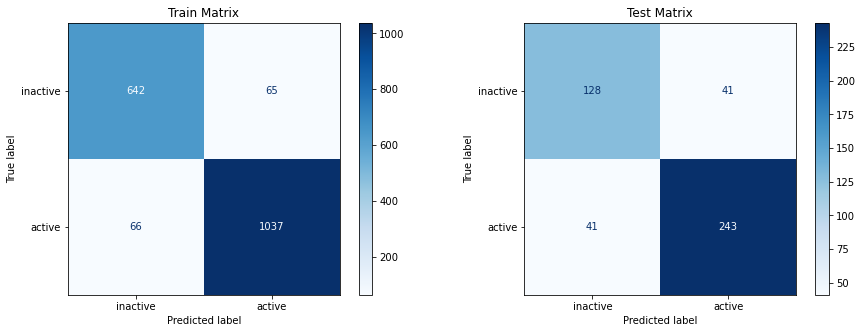

Train scores:
Accuracy:  0.928, ROC/AUC:  0.982
Precision:  0.928, Recall:  0.928, F1 Score:  0.928
Test scores:
Accuracy:  0.819, ROC/AUC:  0.893
Precision:  0.819, Recall:  0.819, F1 Score:  0.819


In [30]:
# Use GridSearch to test a variety of max_depths to decrease the overfitting

# Assign hyperparameters to test
max_depth = list(range(5, 50))

# Create parameter grid
params = [{'max_depth': max_depth}]

# Instantiate model, run and fit GridSearch, then evaluate the best model
rfc_2 = RandomForestClassifier(class_weight='balanced', random_state=6)
gs_rfc_2 = GridSearchCV(rfc_2, params, scoring='precision_weighted', cv=5, verbose=1)
gs_rfc_2.fit(X_train, y_train)
ut.evaluate(gs_rfc_2.best_estimator_, X_train, X_test, y_train, y_test, 'no')

In [31]:
# Add results to dataframe
results.loc[len(results.index)] = ['GS_RFC_2', 0.928, 0.819, 0.928, 0.819]
results

,classifier,f1_train,f1_test,precision_train,precision_test
0,SVC_1,0.84,0.81,0.84,0.82
1,KNC_1,0.84,0.82,0.84,0.82
2,RFC_1,0.95,0.80,0.95,0.80
3,RS_SVC_2,0.90,0.80,0.90,0.80
4,SVC_3-Iso,0.83,0.78,0.83,0.79
5,SVC_4-PCA,0.85,0.82,0.85,0.82
6,RS_SVC_5-PCA,0.92,0.80,0.92,0.80
7,RS_KNC_2,0.81,0.83,0.81,0.83
8,GS_KNC_3,0.82,0.82,0.83,0.82
9,GS_RFC_2,0.93,0.82,0.93,0.82


In [32]:
# Check what max_depth were found to be best
gs_rfc_2.best_params_

{'max_depth': 11}

A max_depth of 11 decreases overfitting slightly and also increases the testing scores. 

### Model 8: Tune RandomForestClassifier hyperparameters using RandomizedSearch

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   13.6s finished


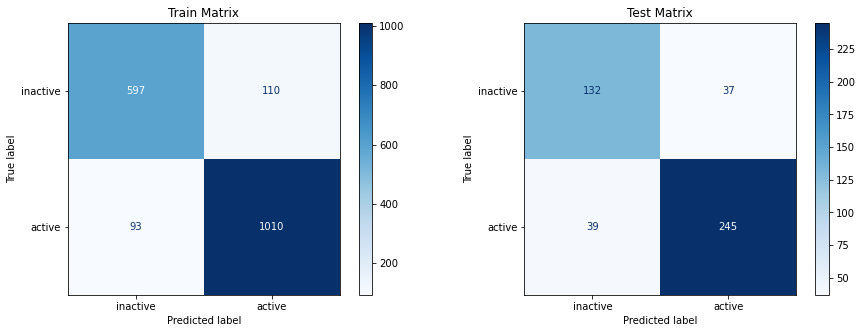

Train scores:
Accuracy:  0.888, ROC/AUC:  0.956
Precision:  0.888, Recall:  0.888, F1 Score:  0.888
Test scores:
Accuracy:  0.832, ROC/AUC:  0.894
Precision:  0.833, Recall:  0.832, F1 Score:  0.832


In [33]:
# Use RandomizedSearch to test a variety of hyperparameters
# Will use the max_depth of 11 from the previous model
     
# Create parameter grid
params = {'ccp_alpha': [0.0, 0.01, 0.1, 1],
          'max_features': [0.3, 'sqrt', 'log2'],
          'max_leaf_nodes': [25, 50, 100, 150, 200],
          'max_samples': [0.2, .5, .7, 1],
          'oob_score':[ False, True]}

# Instantiate model, run and fit RandomizedSearch, then evaluate the best model
rfc_3 = RandomForestClassifier(max_depth=11, class_weight='balanced', random_state=6)
rs_rfc_3 = RandomizedSearchCV(rfc_3, params, scoring='precision_weighted', cv=5, verbose=1)
rs_rfc_3.fit(X_train, y_train)
ut.evaluate(rs_rfc_3, X_train, X_test, y_train, y_test, 'no')

In [34]:
# Add results to dataframe
results.loc[len(results.index)] = ['RS_RFC_3', 0.888, 0.832, 0.888, 0.833]
results

,classifier,f1_train,f1_test,precision_train,precision_test
0,SVC_1,0.84,0.81,0.84,0.82
1,KNC_1,0.84,0.82,0.84,0.82
2,RFC_1,0.95,0.80,0.95,0.80
3,RS_SVC_2,0.90,0.80,0.90,0.80
4,SVC_3-Iso,0.83,0.78,0.83,0.79
5,SVC_4-PCA,0.85,0.82,0.85,0.82
6,RS_SVC_5-PCA,0.92,0.80,0.92,0.80
7,RS_KNC_2,0.81,0.83,0.81,0.83
8,GS_KNC_3,0.82,0.82,0.83,0.82
9,GS_RFC_2,0.93,0.82,0.93,0.82


In [35]:
# Check what parameters were found to be best
rs_rfc_3.best_params_

{'oob_score': True,
 'max_samples': 0.7,
 'max_leaf_nodes': 100,
 'max_features': 0.3,
 'ccp_alpha': 0.0}

The best model from the RandomizedSearch decreased overfitting and increased the test scores as high as the best of the other models. Will next try a GridSearch to tune the best parameters.

### Model 9: Tune RandomForestClassifier hyperparameters using GridSearch

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  1.7min finished


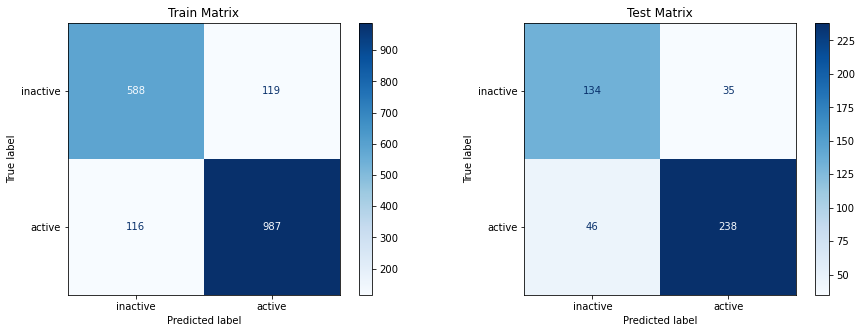

Train scores:
Accuracy:  0.870, ROC/AUC:  0.942
Precision:  0.870, Recall:  0.870, F1 Score:  0.870
Test scores:
Accuracy:  0.821, ROC/AUC:  0.892
Precision:  0.824, Recall:  0.821, F1 Score:  0.822


In [37]:
# Use GridSearch to test a variety of hyperparameters
# Will use the max_depth of 11 from the previous model
     
# Create parameter grid
params = {'max_features': [0.25, 0.3, 0.35],
          'max_leaf_nodes': [75, 100, 125],
          'max_samples': [0.6, 0.7, 0.8],
          'oob_score':[True]}

# Instantiate model, run and fit GridSearch, then evaluate the best model
rfc_4 = RandomForestClassifier(max_depth=11, class_weight='balanced', random_state=6)
gs_rfc_4 = GridSearchCV(rfc_4, params, scoring='precision_weighted', cv=5, verbose=1)
gs_rfc_4.fit(X_train, y_train)
ut.evaluate(gs_rfc_4, X_train, X_test, y_train, y_test, 'no')

In [38]:
# Add results to dataframe
results.loc[len(results.index)] = ['GS_RFC_4', 0.870, 0.822, 0.870, 0.824]
results

,classifier,f1_train,f1_test,precision_train,precision_test
0,SVC_1,0.84,0.81,0.84,0.82
1,KNC_1,0.84,0.82,0.84,0.82
2,RFC_1,0.95,0.80,0.95,0.80
3,RS_SVC_2,0.90,0.80,0.90,0.80
4,SVC_3-Iso,0.83,0.78,0.83,0.79
5,SVC_4-PCA,0.85,0.82,0.85,0.82
6,RS_SVC_5-PCA,0.92,0.80,0.92,0.80
7,RS_KNC_2,0.81,0.83,0.81,0.83
8,GS_KNC_3,0.82,0.82,0.83,0.82
9,GS_RFC_2,0.93,0.82,0.93,0.82


In [39]:
# Check what parameters were found to be best
gs_rfc_4.best_params_

{'max_features': 0.25,
 'max_leaf_nodes': 75,
 'max_samples': 0.8,
 'oob_score': True}

Again, the grid search improved the train scores, but not the test scores. The best model was the one found by the randomized search.

### Stacking the Best Models

A stacked model uses the results of several models to make its predictions. Will use sklearn's StackingClassifier to stack the three best models and see if their combined predictions will lead to a better model.

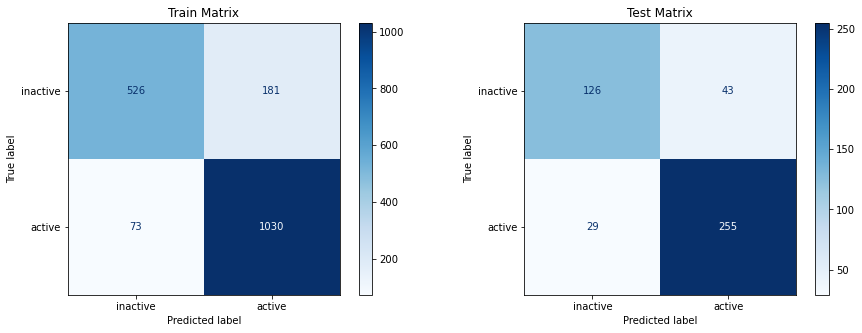

Train scores:
Accuracy:  0.860, ROC/AUC:  0.946
Precision:  0.861, Recall:  0.860, F1 Score:  0.857
Test scores:
Accuracy:  0.841, ROC/AUC:  0.897
Precision:  0.840, Recall:  0.841, F1 Score:  0.840


In [40]:
# Define the models, parameters are based on the best models from above
estimators = [('svr', make_pipeline(PCA(), SVC(random_state=6))),
              ('knc', KNeighborsClassifier(weights='uniform', p= 1, n_neighbors=9,
                                            metric='minkowski', leaf_size=50)),
              ('rfc', RandomForestClassifier(max_depth=11, oob_score=True, max_samples=0.7,
                                             max_leaf_nodes=100, max_features=0.3,
                                             ccp_alpha=0.0, random_state=6))] 

# Instantiate, fit and evaluate the StackingClassifier
stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stack.fit(X_train, y_train)
ut.evaluate(stack, X_train, X_test, y_train, y_test, 'no')

In [41]:
# Add results to dataframe
results.loc[len(results.index)] = ['stack', 0.857, 0.840, 0.861, 0.840]
results

,classifier,f1_train,f1_test,precision_train,precision_test
0,SVC_1,0.84,0.81,0.84,0.82
1,KNC_1,0.84,0.82,0.84,0.82
2,RFC_1,0.95,0.80,0.95,0.80
3,RS_SVC_2,0.90,0.80,0.90,0.80
4,SVC_3-Iso,0.83,0.78,0.83,0.79
5,SVC_4-PCA,0.85,0.82,0.85,0.82
6,RS_SVC_5-PCA,0.92,0.80,0.92,0.80
7,RS_KNC_2,0.81,0.83,0.81,0.83
8,GS_KNC_3,0.82,0.82,0.83,0.82
9,GS_RFC_2,0.93,0.82,0.93,0.82


The stacked model performed better both with higher precision and f1 scores and with less overfitting. I will save this model as the final model of this project.

In [43]:
# Save the model
filename = 'stacked_model.sav'
pickle.dump(stack, open(filename, 'wb'))

## Final Evaluation

### Get Feature Importances of 3 best models

To further evaluate the final model, I would like to see which PubChem fingerprints each model found to be more important in predicting the modelcule's activity.

In [163]:
%%script echo skipping
# Create dataframe with 2 columns: feature names and feature importance

# RandomForest feature importances dataframe using the attribute
features_rfc = pd.DataFrame(zip(list(X_test.columns), list(rs_rfc_3.best_estimator_.feature_importances_)))

# KNeighbors feature importances using sklearn's permutation importance
results_knc = permutation_importance(rs_knc_2.best_estimator_, X_test, y_test)
importance_knc = results_knc.importances_mean
features_knc = pd.DataFrame(zip(list(X_test.columns), list(importance_knc)))

# SVC feature importances using sklearn's permutation importance
# note: because the best SVC model used PCA, the feature importance of the 2nd best SVC model is used here
results_svc = permutation_importance(svc, X_test, y_test)
importance_svc = results_svc.importances_mean
features_svc = pd.DataFrame(zip(list(X_test.columns), list(importance_svc)))


In [164]:
%%script echo skipping
# Create a list with the top 15 features from each model
# Also print top feature for each model

impt_features = []
for features in [features_rfc, features_knc, features_svc]:
    sorted_feat = features.sort_values(by=1, ascending=False)
    top_15 = list(sorted_feat[0][:15])
    print(top_15[0])
    impt_features += top_15

PubchemFP783
PubchemFP16
PubchemFP645


In [165]:
%%script echo skipping
# Find items in the list that are present more than once
counts = Counter(impt_features)
[(k, v) for (k, v) in counts.items() if v > 1]

[('PubchemFP301', 2),
 ('PubchemFP514', 2),
 ('PubchemFP698', 2),
 ('PubchemFP704', 2),
 ('PubchemFP395', 3),
 ('PubchemFP335', 2),
 ('PubchemFP695', 2),
 ('PubchemFP645', 2)]

In [25]:
# https://ftp.ncbi.nlm.nih.gov/pubchem/specifications/pubchem_fingerprints.txt

FP783 = 'OC1CCC(S)CC1'
FP16 = '>=4N'   # This is not a structure- just that the molecule contains at least four Nitrogens
FP645 = 'C(=O)NCC'

FP695 = 'C(=O)CCCCN'
FP335 = 'C(C)(C)(C)'
FP301 = 'NO'
FP514 = 'ONCC'
FP698 = 'OCCCCCCC'
FP704 = 'C(=O)CCCCCC'
FP395 = 'C(O)'

multiple_feature_smiles = [FP695, FP335, FP301, FP514, FP698, FP704, FP395, FP645]
num_1_feature_smiles = [FP783, FP645]
feature_smiles = multiple_feature_smiles + num_1_feature_smiles

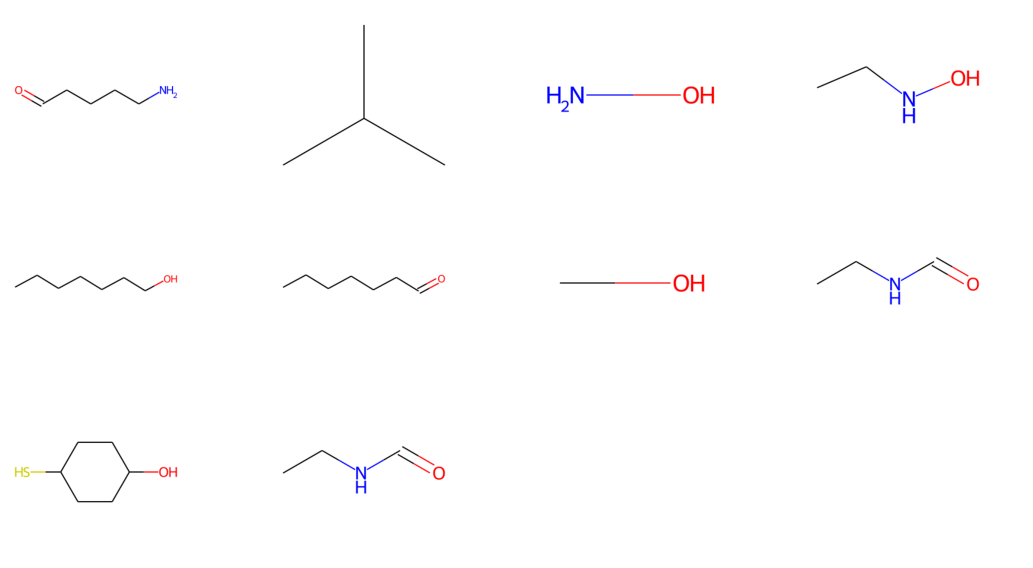

In [26]:
fig, axes = plt.subplots(3, 4, figsize=(15,8), sharex=True, sharey=True)
axr = axes.ravel()
for ax in axr:
    ax.set_axis_off()
fig.tight_layout()

for i, mol in enumerate(feature_smiles):
    m = Chem.MolFromSmiles(mol)
    AllChem.Compute2DCoords(m)
    img=Draw.MolToImage(m)
    axr[i].set_axis_on()
    axr[i].imshow(img)
    axr[i].axis('off')

Next, I would like to visualize some of the molecules that were correctly and incorrectly identified. 

In [12]:
# First I need to get the predicted target values for the test data

# Load the best model
best_model = pickle.load(open('stacked_model.sav', 'rb'))
# Get target predictions
y_preds = best_model.predict(X_test)

In [13]:
# Next, the actual and predicted target values need to be matched back to the ChEMBL ID 
# that is the index of the X_test dataset

# Turn the needed arrays into DataFrames/Series so they can be concatenated
X_test_df = pd.DataFrame(X_test)
y_test_se = pd.Series(y_test)
y_preds_se = pd.Series(y_preds)
# Concatenate X with actual target values, then concatenate that dataframe with the predicted values
chembl_y_df = pd.concat([X_test_df.reset_index(), y_test_se.reset_index(drop=True)], axis=1)
chembl_y_df = pd.concat([chembl_y_df.reset_index(drop=True), y_preds_se.reset_index(drop=True)], axis=1)
chembl_y_df.head()

,Name,PubchemFP15,PubchemFP16,PubchemFP33,PubchemFP143,PubchemFP145,PubchemFP146,PubchemFP180,PubchemFP181,PubchemFP186,...,PubchemFP698,PubchemFP699,PubchemFP704,PubchemFP712,PubchemFP714,PubchemFP720,PubchemFP777,PubchemFP783,target,0
0,CHEMBL2336345,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,1,0,1,1
1,CHEMBL249862,1,1,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL254838,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL4208646,0,0,0,0,0,0,0,1,1,...,1,1,1,1,1,0,1,0,1,0
4,CHEMBL3617407,1,0,1,1,1,1,0,0,1,...,1,1,1,1,1,0,1,0,1,1


In [14]:
# Identify rows with correctly predicted inactive and active compounds
# as well as those that were false negatives and false positives

inactive = chembl_y_df.loc[(chembl_y_df['target']==0) & (chembl_y_df[0]==0)]
active = chembl_y_df.loc[(chembl_y_df['target']==1) & (chembl_y_df[0]==1)]
false_neg = chembl_y_df.loc[(chembl_y_df['target']==1) & (chembl_y_df[0]==0)]
false_pos = chembl_y_df.loc[(chembl_y_df['target']==0) & (chembl_y_df[0]==1)]

In [15]:
# The function to view molecules from a dataframe requires input
# of a dictionary with ChEMBL IDs as keys and canonical smiles as values
di = dict(zip(list(lipinski['molecule_chembl_id']), list(lipinski['canonical_smiles'])))

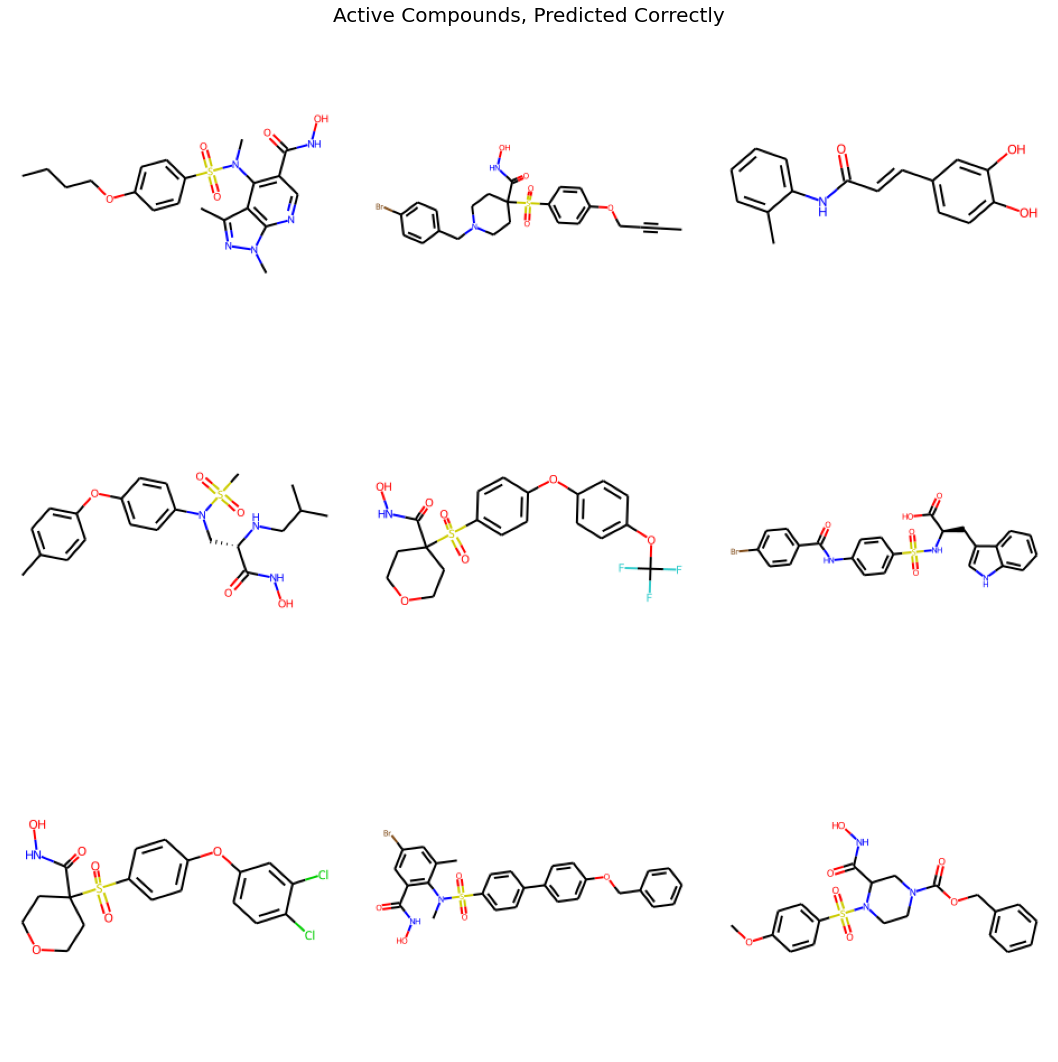

In [20]:
# View 9 molecules from the active dataframe
ut.view_molecules(active, di, 9, title="Active Compounds, Predicted Correctly")

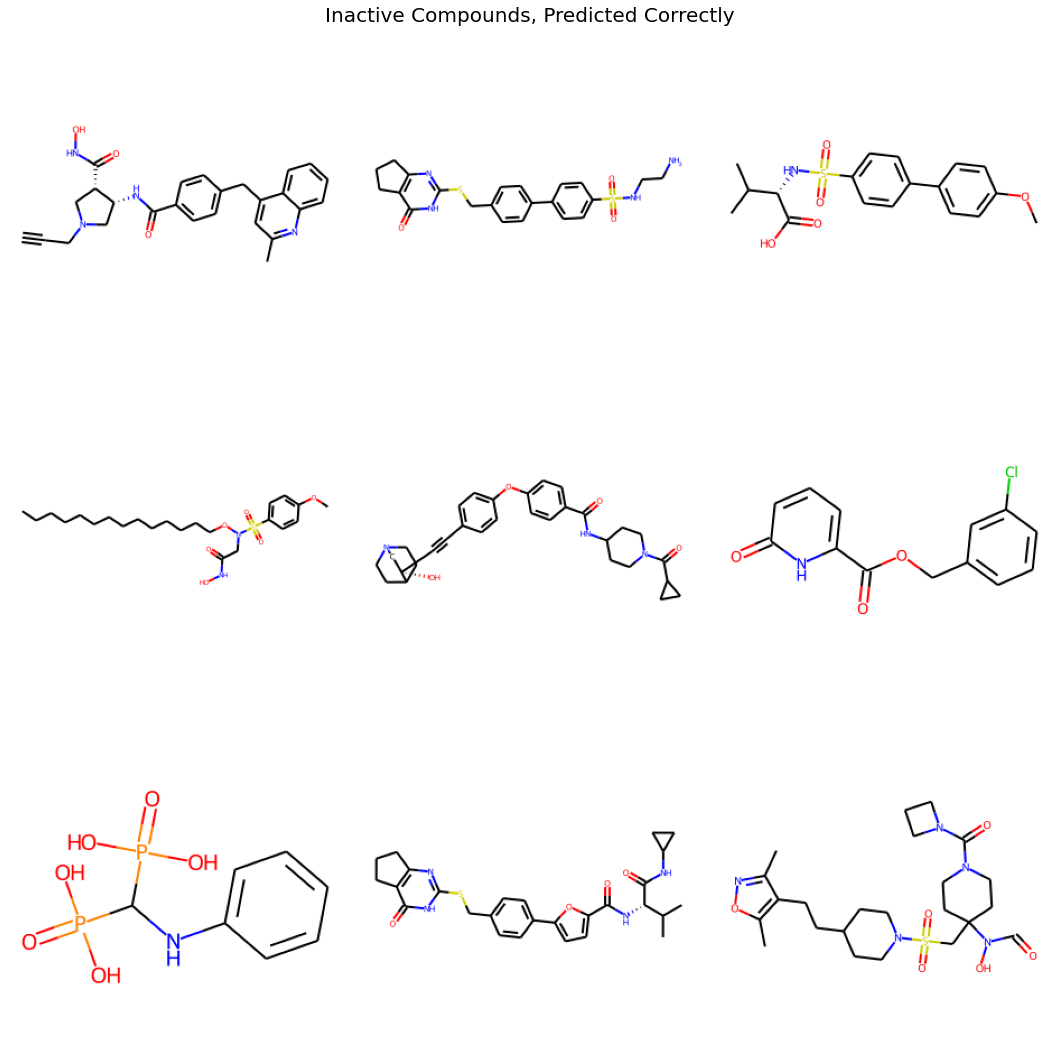

In [21]:
# View 9 molecules from the inactive dataframe
ut.view_molecules(inactive, di, 9, title="Inactive Compounds, Predicted Correctly")

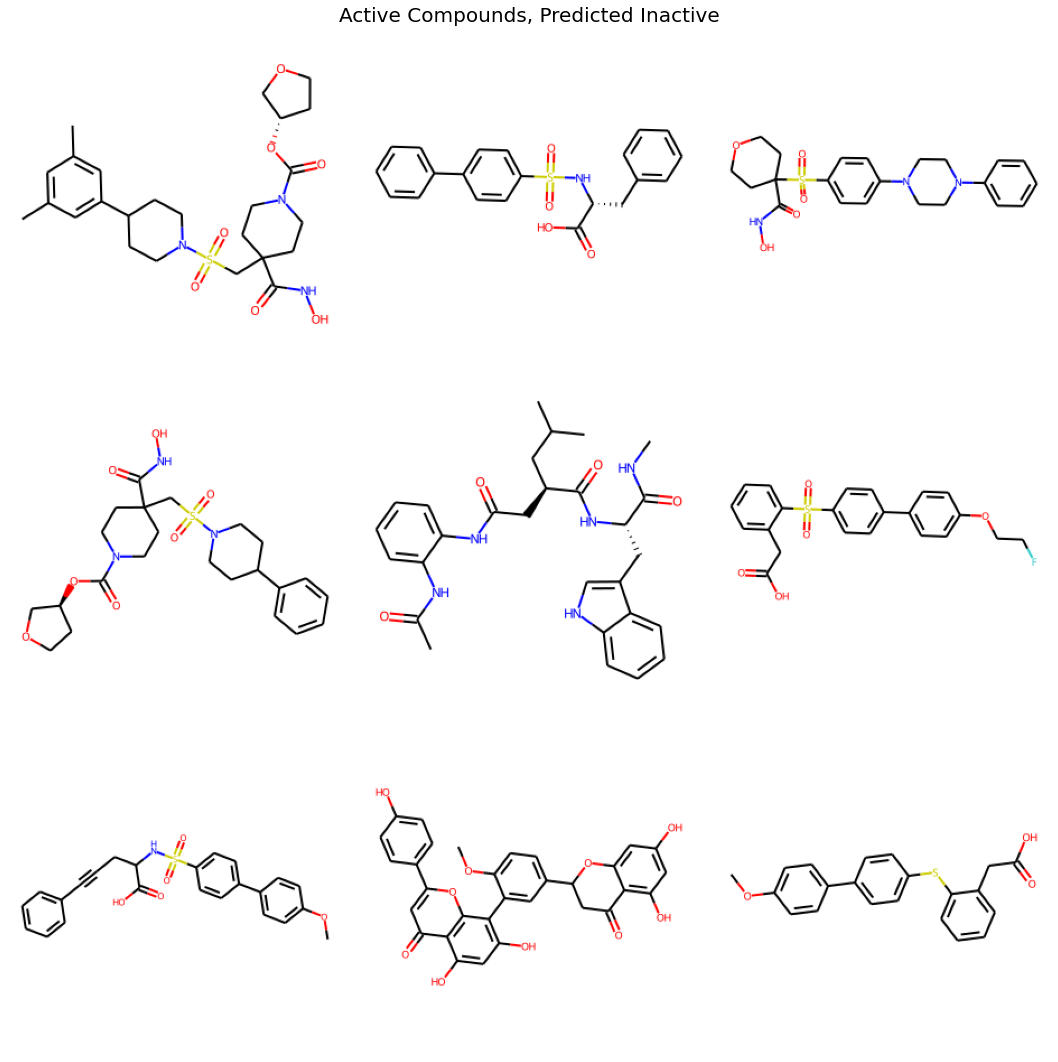

In [22]:
# View 9 molecules from the false negatives dataframe
ut.view_molecules(false_neg, di, 9, title="Active Compounds, Predicted Inactive")

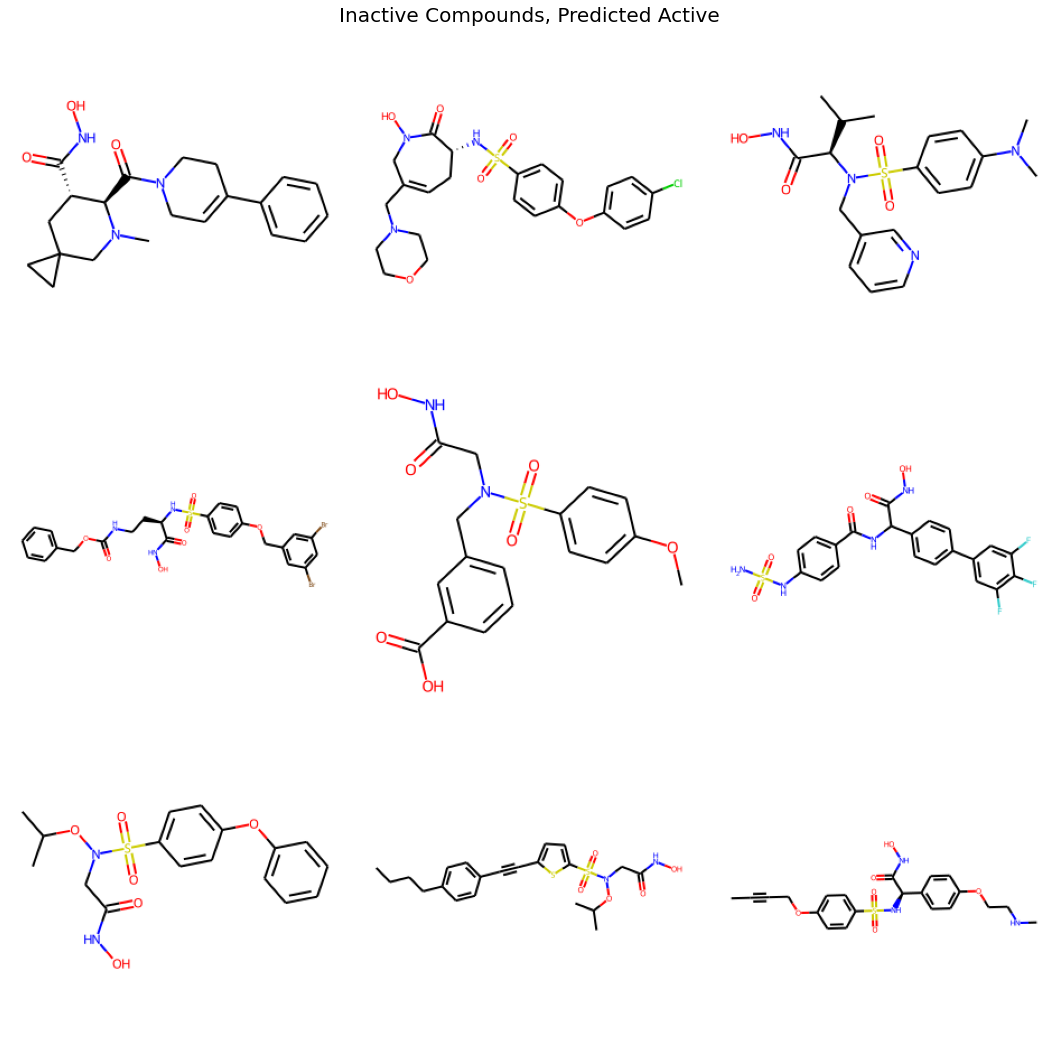

In [23]:
# View 9 molecules from the false positive dataframe
ut.view_molecules(false_pos, di, 9, title="Inactive Compounds, Predicted Active")

In [67]:
# Create a correlation matrix
X_corr = pd.DataFrame(X_train)
corrMatrix = X_corr.corr().abs()
s = corrMatrix.unstack()
so = pd.DataFrame(s.sort_values())
# Find features with significant correlations
so.loc[(so[0] < 1) & (so[0]>=0.75)]



upper_tri = corrMatrix.where(np.triu(np.ones(corrMatrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.75)]
print(to_drop, len(to_drop))

[4, 5, 7, 13, 23, 25, 27, 30, 32, 33, 34, 36, 39, 40, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 89, 90, 91, 94, 95, 96, 97, 98, 100, 101, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 114, 116, 119, 120, 121, 123, 124, 125, 126, 127, 128, 129, 130, 133, 134, 135, 141, 145, 146] 92


## Conclusion

## Future Directions